This notebook calculates the Mahalanobis distance between points on a pca. 
I will document more about what Mahalanobis distance is and how it is calculated in this notebook.

In [1]:
import itertools
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from scipy.spatial.distance import mahalanobis
from scipy.stats import f_oneway as anova
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# set the path to the data
mean_aggregated_data_pca_path = pathlib.Path(
    "../../data/6.analysis_results/mean_aggregated_pca.parquet"
).resolve(strict=True)

# read the data
mean_aggregated_data_pca = pd.read_parquet(mean_aggregated_data_pca_path)
print(mean_aggregated_data_pca.shape)
mean_aggregated_data_pca.head()

(83, 86)


,Metadata_genotype,Metadata_replicate,Metadata_side,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83
0,High-Severity,1,L,-7.710260,-4.264421,1.521397,-1.390342,9.410620,-6.054486,1.336078,...,0.213169,0.034717,0.129185,-0.146640,-0.081667,-0.075119,-0.020639,0.058634,0.028028,9.906943e-16
1,High-Severity,1,R,0.695800,8.170808,-1.217780,-2.386591,-2.609680,1.468471,4.371038,...,-0.215559,-0.068413,-0.266401,-0.023500,-0.054200,-0.023511,0.119934,0.145838,0.035305,-8.556710e-17
2,High-Severity,10,L,6.910961,11.252120,-2.831527,-3.131419,-2.634531,3.551757,-2.684211,...,-0.075988,-0.123323,-0.210824,0.063699,0.148910,0.041040,0.020007,0.161693,-0.143457,-4.445563e-16
3,High-Severity,10,R,2.179877,6.184598,-3.463740,-0.260566,-3.067898,1.597567,2.061996,...,0.416289,0.348893,0.151410,0.326023,-0.207744,0.234788,-0.024102,-0.150510,0.049366,3.319675e-17
4,High-Severity,11,L,1.336690,9.305025,3.279230,0.938479,6.459164,-4.944010,-1.393619,...,-0.028287,0.092703,0.038004,0.095451,0.043627,0.006402,-0.030578,-0.017234,0.008486,-1.129520e-15


# Mahalanobis Distance
For more in depth information on Mahalanobis distance, please refer to this [link](https://medium.com/@the_daft_introvert/mahalanobis-distance-5c11a757b099).
Mahalanobis distance is a measure of the distance between a point P and a distribution D. 
It is a multi-dimensional generalization of the idea of measuring how many standard deviations away P is from the mean of D. 
This distance is zero if P is at the mean of D, and grows as P moves away from the mean along each principal component axis.
The formula for Mahalanobis distance is given by:
### $D^2 = (x - \mu)^T \Sigma^{-1} (x - \mu)$
where:
- $D$ is the Mahalanobis distance

## Caluclating Mahalanobis Distance on PCA 
Here I calculate the Mahalanobis distance between the points on the first two principal components of the data for each of the three genotypes.

In [3]:
# split the genotypes
high_severity = mean_aggregated_data_pca[
    mean_aggregated_data_pca["Metadata_genotype"] == "High-Severity"
]
low_severity = mean_aggregated_data_pca[
    mean_aggregated_data_pca["Metadata_genotype"] == "Mid-Severity"
]
wt = mean_aggregated_data_pca[
    mean_aggregated_data_pca["Metadata_genotype"] == "Wild Type"
]
print(len(high_severity), len(low_severity), len(wt))

28 27 28


In [4]:
# drop the the Metadata columns
metadata_columns = high_severity.columns[high_severity.columns.str.contains("Metadata")]
high_severity = high_severity.drop(metadata_columns, axis=1)
low_severity = low_severity.drop(metadata_columns, axis=1)
wt = wt.drop(metadata_columns, axis=1)


# convert the df to coordinates
high_severity_coords = high_severity.to_numpy()
low_severity_coords = low_severity.to_numpy()
wt_coords = wt.to_numpy()
print(high_severity_coords.shape, low_severity_coords.shape, wt_coords.shape)

(28, 83) (27, 83) (28, 83)


#### High-Severity

In [5]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(high_severity_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
high_severity_mahalanobis_distances = []
# calculate the mahalanobis distance for each point combination
for point in itertools.combinations(high_severity_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    high_severity_mahalanobis_distances.append(distance)
mean_high_severity_mahalanobis_distance = np.mean(high_severity_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the High-Severity genotype is {mean_high_severity_mahalanobis_distance}"
)

The mean mahalanobis distance for the High-Severity genotype is 11.762056342410409


/home/lippincm/miniforge3/envs/op_cell_processing_env/lib/python3.8/site-packages/scipy/spatial/distance.py:1064: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


#### Low-Severity

In [6]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(low_severity_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
low_severity_mahalanobis_distances = []
# calculate the mahalanobis distance for each point
for point in itertools.combinations(low_severity_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    low_severity_mahalanobis_distances.append(distance)
mean_low_severity_mahalanobis_distance = np.mean(low_severity_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the low-Severity genotype is {mean_low_severity_mahalanobis_distance}"
)

The mean mahalanobis distance for the low-Severity genotype is 13.336934733749693


#### Wild Type

In [7]:
# define the mean and the inverse covariance matrix needed for the mahalanobis distance calculation
cov_matrix = np.cov(wt_coords, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)
# calculate the mahalanobis distance for each point within each genotype
wt_mahalanobis_distances = []
# calculate the mahalanobis distance for each point
for point in itertools.combinations(wt_coords, 2):
    distance = mahalanobis(point[0], point[1], inv_cov_matrix)
    if np.isnan(distance):  # Check for NaN values
        continue
    wt_mahalanobis_distances.append(distance)
mean_wt_mahalanobis_distance = np.mean(wt_mahalanobis_distances)
print(
    f"The mean mahalanobis distance for the Wild Type genotype is {mean_wt_mahalanobis_distance}"
)

The mean mahalanobis distance for the Wild Type genotype is 10.91427607576582


## Calculate the Mahalanobis distance for random shuffled data points

In [8]:
# from the distribution of each PCA component, randomly sample 1000 points and calculate the mahalanobis distance
# get the distribution of each PCA component
high_severity_pca_component_distribution_std = high_severity.describe().loc["std"]
low_severity_pca_component_distribution_std = low_severity.describe().loc["std"]
wt_pca_component_distribution_std = wt.describe().loc["std"]

high_severity_pca_component_distribution_mean = high_severity.describe().loc["mean"]
low_severity_pca_component_distribution_mean = low_severity.describe().loc["mean"]
wt_pca_component_distribution_mean = wt.describe().loc["mean"]

In [9]:
# do 1000 trials of sampling from each PCA component distribution
# from the distribution of each PCA component, randomly sample 1000 points and calculate the mahalanobis distance

# set the output mean Mahalanobis distance lists per genotype
mean_high_severity_sampled_mahalanobis_distances_from_trials = []
mean_low_severity_sampled_mahalanobis_distances_from_trials = []
mean_wt_sampled_mahalanobis_distances_from_trials = []

# sample 1000 points from the distribution of each PCA component
num_pca_components = high_severity_pca_component_distribution_std.shape[0]
num_samples = 100
num_trials = 1000

for trial in tqdm.tqdm(range(num_trials)):
    high_severity_sampled_points = pd.DataFrame()
    low_severity_sampled_points = pd.DataFrame()
    wt_sampled_points = pd.DataFrame()

    for i in range(num_pca_components):
        high_severity_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=high_severity_pca_component_distribution_mean[i],
            scale=high_severity_pca_component_distribution_std[i],
            size=num_samples,
        )
        low_severity_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=low_severity_pca_component_distribution_mean[i],
            scale=low_severity_pca_component_distribution_std[i],
            size=num_samples,
        )
        wt_sampled_points[f"PC{i+1}"] = np.random.normal(
            loc=wt_pca_component_distribution_mean[i],
            scale=wt_pca_component_distribution_std[i],
            size=num_samples,
        )

    inv_cov_matrix = np.linalg.inv(
        np.cov(high_severity_sampled_points.to_numpy(), rowvar=False)
    )
    # calculate the mahalanobis distance for each point within each genotype
    high_severity_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(high_severity_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        high_severity_sampled_mahalanobis_distances.append(distance)

    mean_high_severity_sampled_mahalanobis_distance = np.mean(
        high_severity_sampled_mahalanobis_distances
    )

    inv_cov_matrix = np.linalg.inv(
        np.cov(low_severity_sampled_points.to_numpy(), rowvar=False)
    )
    # calculate the mahalanobis distance for each point within each genotype
    low_severity_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(low_severity_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        low_severity_sampled_mahalanobis_distances.append(distance)

    mean_low_severity_sampled_mahalanobis_distance = np.mean(
        low_severity_sampled_mahalanobis_distances
    )

    inv_cov_matrix = np.linalg.inv(np.cov(wt_sampled_points.to_numpy(), rowvar=False))
    # calculate the mahalanobis distance for each point within each genotype
    wt_sampled_mahalanobis_distances = []
    # calculate the mahalanobis distance for each point combination
    for point in itertools.combinations(wt_sampled_points.to_numpy(), 2):
        distance = mahalanobis(point[0], point[1], inv_cov_matrix)
        if np.isnan(distance):  # Check for NaN values
            continue
        wt_sampled_mahalanobis_distances.append(distance)

    mean_wt_sampled_mahalanobis_distance = np.mean(wt_sampled_mahalanobis_distances)

    # append the average mahalanobis distance from the trial to the list for the trial per genotype
    mean_high_severity_sampled_mahalanobis_distances_from_trials.append(
        mean_high_severity_sampled_mahalanobis_distance
    )
    mean_low_severity_sampled_mahalanobis_distances_from_trials.append(
        mean_low_severity_sampled_mahalanobis_distance
    )
    mean_wt_sampled_mahalanobis_distances_from_trials.append(
        mean_wt_sampled_mahalanobis_distance
    )

  0%|                                              | 0/1000 [00:00<?, ?it/s]

  0%|                                      | 1/1000 [00:00<02:44,  6.06it/s]

  0%|                                      | 2/1000 [00:00<02:47,  5.94it/s]

  0%|                                      | 3/1000 [00:00<02:48,  5.92it/s]

  0%|▏                                     | 4/1000 [00:00<02:49,  5.89it/s]

  0%|▏                                     | 5/1000 [00:00<02:49,  5.88it/s]

  1%|▏                                     | 6/1000 [00:01<02:48,  5.89it/s]

  1%|▎                                     | 7/1000 [00:01<02:48,  5.90it/s]

  1%|▎                                     | 8/1000 [00:01<02:47,  5.91it/s]

  1%|▎                                     | 9/1000 [00:01<02:48,  5.89it/s]

  1%|▎                                    | 10/1000 [00:01<02:47,  5.91it/s]

  1%|▍                                    | 11/1000 [00:01<02:47,  5.91it/s]

  1%|▍                                    | 12/1000 [00:02<02:46,  5.93it/s]

  1%|▍                                    | 13/1000 [00:02<02:46,  5.92it/s]

  1%|▌                                    | 14/1000 [00:02<02:46,  5.92it/s]

  2%|▌                                    | 15/1000 [00:02<02:46,  5.91it/s]

  2%|▌                                    | 16/1000 [00:02<02:46,  5.91it/s]

  2%|▋                                    | 17/1000 [00:02<02:46,  5.91it/s]

  2%|▋                                    | 18/1000 [00:03<02:46,  5.91it/s]

  2%|▋                                    | 19/1000 [00:03<02:45,  5.92it/s]

  2%|▋                                    | 20/1000 [00:03<02:45,  5.91it/s]

  2%|▊                                    | 21/1000 [00:03<02:45,  5.91it/s]

  2%|▊                                    | 22/1000 [00:03<02:45,  5.90it/s]

  2%|▊                                    | 23/1000 [00:03<02:45,  5.89it/s]

  2%|▉                                    | 24/1000 [00:04<02:45,  5.90it/s]

  2%|▉                                    | 25/1000 [00:04<02:45,  5.90it/s]

  3%|▉                                    | 26/1000 [00:04<02:45,  5.89it/s]

  3%|▉                                    | 27/1000 [00:04<02:45,  5.87it/s]

  3%|█                                    | 28/1000 [00:04<02:45,  5.87it/s]

  3%|█                                    | 29/1000 [00:04<02:45,  5.87it/s]

  3%|█                                    | 30/1000 [00:05<02:45,  5.88it/s]

  3%|█▏                                   | 31/1000 [00:05<02:44,  5.88it/s]

  3%|█▏                                   | 32/1000 [00:05<02:54,  5.54it/s]

  3%|█▏                                   | 33/1000 [00:05<03:03,  5.26it/s]

  3%|█▎                                   | 34/1000 [00:05<03:14,  4.98it/s]

  4%|█▎                                   | 35/1000 [00:06<03:04,  5.22it/s]

  4%|█▎                                   | 36/1000 [00:06<02:58,  5.41it/s]

  4%|█▎                                   | 37/1000 [00:06<03:52,  4.15it/s]

  4%|█▍                                   | 38/1000 [00:06<03:32,  4.53it/s]

  4%|█▍                                   | 39/1000 [00:06<03:17,  4.85it/s]

  4%|█▍                                   | 40/1000 [00:07<03:07,  5.12it/s]

  4%|█▌                                   | 41/1000 [00:07<03:00,  5.33it/s]

  4%|█▌                                   | 42/1000 [00:07<02:55,  5.46it/s]

  4%|█▌                                   | 43/1000 [00:07<02:56,  5.42it/s]

  4%|█▋                                   | 44/1000 [00:07<02:53,  5.51it/s]

  4%|█▋                                   | 45/1000 [00:08<03:10,  5.00it/s]

  5%|█▋                                   | 46/1000 [00:08<03:02,  5.23it/s]

  5%|█▋                                   | 47/1000 [00:08<02:56,  5.41it/s]

  5%|█▊                                   | 48/1000 [00:08<02:51,  5.54it/s]

  5%|█▊                                   | 49/1000 [00:08<02:49,  5.62it/s]

  5%|█▊                                   | 50/1000 [00:08<02:48,  5.62it/s]

  5%|█▉                                   | 51/1000 [00:09<02:48,  5.65it/s]

  5%|█▉                                   | 52/1000 [00:09<02:46,  5.71it/s]

  5%|█▉                                   | 53/1000 [00:09<02:50,  5.54it/s]

  5%|█▉                                   | 54/1000 [00:09<02:48,  5.62it/s]

  6%|██                                   | 55/1000 [00:09<02:45,  5.70it/s]

  6%|██                                   | 56/1000 [00:09<02:46,  5.66it/s]

  6%|██                                   | 57/1000 [00:10<02:47,  5.63it/s]

  6%|██▏                                  | 58/1000 [00:10<02:45,  5.69it/s]

  6%|██▏                                  | 59/1000 [00:10<02:43,  5.74it/s]

  6%|██▏                                  | 60/1000 [00:10<02:43,  5.76it/s]

  6%|██▎                                  | 61/1000 [00:10<02:42,  5.77it/s]

  6%|██▎                                  | 62/1000 [00:11<02:41,  5.80it/s]

  6%|██▎                                  | 63/1000 [00:11<02:41,  5.82it/s]

  6%|██▎                                  | 64/1000 [00:11<02:40,  5.83it/s]

  6%|██▍                                  | 65/1000 [00:11<02:39,  5.86it/s]

  7%|██▍                                  | 66/1000 [00:11<02:39,  5.86it/s]

  7%|██▍                                  | 67/1000 [00:11<02:39,  5.85it/s]

  7%|██▌                                  | 68/1000 [00:12<02:38,  5.87it/s]

  7%|██▌                                  | 69/1000 [00:12<02:38,  5.87it/s]

  7%|██▌                                  | 70/1000 [00:12<02:38,  5.88it/s]

  7%|██▋                                  | 71/1000 [00:12<02:37,  5.88it/s]

  7%|██▋                                  | 72/1000 [00:12<02:38,  5.87it/s]

  7%|██▋                                  | 73/1000 [00:12<02:38,  5.85it/s]

  7%|██▋                                  | 74/1000 [00:13<02:37,  5.87it/s]

  8%|██▊                                  | 75/1000 [00:13<02:37,  5.86it/s]

  8%|██▊                                  | 76/1000 [00:13<02:37,  5.85it/s]

  8%|██▊                                  | 77/1000 [00:13<02:37,  5.86it/s]

  8%|██▉                                  | 78/1000 [00:13<02:37,  5.86it/s]

  8%|██▉                                  | 79/1000 [00:13<02:37,  5.85it/s]

  8%|██▉                                  | 80/1000 [00:14<02:37,  5.86it/s]

  8%|██▉                                  | 81/1000 [00:14<02:36,  5.86it/s]

  8%|███                                  | 82/1000 [00:14<02:36,  5.86it/s]

  8%|███                                  | 83/1000 [00:14<02:36,  5.86it/s]

  8%|███                                  | 84/1000 [00:14<02:36,  5.86it/s]

  8%|███▏                                 | 85/1000 [00:14<02:36,  5.85it/s]

  9%|███▏                                 | 86/1000 [00:15<02:36,  5.85it/s]

  9%|███▏                                 | 87/1000 [00:15<02:35,  5.86it/s]

  9%|███▎                                 | 88/1000 [00:15<02:35,  5.85it/s]

  9%|███▎                                 | 89/1000 [00:15<02:35,  5.85it/s]

  9%|███▎                                 | 90/1000 [00:15<02:35,  5.85it/s]

  9%|███▎                                 | 91/1000 [00:15<02:35,  5.85it/s]

  9%|███▍                                 | 92/1000 [00:16<02:35,  5.83it/s]

  9%|███▍                                 | 93/1000 [00:16<02:37,  5.77it/s]

  9%|███▍                                 | 94/1000 [00:16<02:36,  5.80it/s]

 10%|███▌                                 | 95/1000 [00:16<02:35,  5.82it/s]

 10%|███▌                                 | 96/1000 [00:16<02:35,  5.83it/s]

 10%|███▌                                 | 97/1000 [00:17<02:34,  5.85it/s]

 10%|███▋                                 | 98/1000 [00:17<02:34,  5.84it/s]

 10%|███▋                                 | 99/1000 [00:17<02:33,  5.85it/s]

 10%|███▌                                | 100/1000 [00:17<02:33,  5.86it/s]

 10%|███▋                                | 101/1000 [00:17<02:33,  5.86it/s]

 10%|███▋                                | 102/1000 [00:17<02:33,  5.85it/s]

 10%|███▋                                | 103/1000 [00:18<02:33,  5.86it/s]

 10%|███▋                                | 104/1000 [00:18<02:34,  5.82it/s]

 10%|███▊                                | 105/1000 [00:18<02:34,  5.79it/s]

 11%|███▊                                | 106/1000 [00:18<02:38,  5.63it/s]

 11%|███▊                                | 107/1000 [00:18<02:37,  5.69it/s]

 11%|███▉                                | 108/1000 [00:18<02:35,  5.72it/s]

 11%|███▉                                | 109/1000 [00:19<02:34,  5.76it/s]

 11%|███▉                                | 110/1000 [00:19<02:34,  5.77it/s]

 11%|███▉                                | 111/1000 [00:19<02:33,  5.79it/s]

 11%|████                                | 112/1000 [00:19<02:32,  5.81it/s]

 11%|████                                | 113/1000 [00:19<02:32,  5.81it/s]

 11%|████                                | 114/1000 [00:19<02:32,  5.82it/s]

 12%|████▏                               | 115/1000 [00:20<02:32,  5.82it/s]

 12%|████▏                               | 116/1000 [00:20<02:31,  5.83it/s]

 12%|████▏                               | 117/1000 [00:20<02:30,  5.85it/s]

 12%|████▏                               | 118/1000 [00:20<02:33,  5.74it/s]

 12%|████▎                               | 119/1000 [00:20<02:33,  5.73it/s]

 12%|████▎                               | 120/1000 [00:20<02:32,  5.75it/s]

 12%|████▎                               | 121/1000 [00:21<02:33,  5.74it/s]

 12%|████▍                               | 122/1000 [00:21<02:34,  5.70it/s]

 12%|████▍                               | 123/1000 [00:21<02:33,  5.71it/s]

 12%|████▍                               | 124/1000 [00:21<02:34,  5.69it/s]

 12%|████▌                               | 125/1000 [00:21<02:32,  5.73it/s]

 13%|████▌                               | 126/1000 [00:22<02:32,  5.75it/s]

 13%|████▌                               | 127/1000 [00:22<02:31,  5.77it/s]

 13%|████▌                               | 128/1000 [00:22<02:30,  5.80it/s]

 13%|████▋                               | 129/1000 [00:22<02:29,  5.81it/s]

 13%|████▋                               | 130/1000 [00:22<02:29,  5.82it/s]

 13%|████▋                               | 131/1000 [00:22<02:29,  5.82it/s]

 13%|████▊                               | 132/1000 [00:23<02:30,  5.77it/s]

 13%|████▊                               | 133/1000 [00:23<02:29,  5.78it/s]

 13%|████▊                               | 134/1000 [00:23<02:29,  5.80it/s]

 14%|████▊                               | 135/1000 [00:23<02:29,  5.80it/s]

 14%|████▉                               | 136/1000 [00:23<02:29,  5.79it/s]

 14%|████▉                               | 137/1000 [00:23<02:28,  5.81it/s]

 14%|████▉                               | 138/1000 [00:24<02:27,  5.83it/s]

 14%|█████                               | 139/1000 [00:24<02:27,  5.82it/s]

 14%|█████                               | 140/1000 [00:24<02:27,  5.84it/s]

 14%|█████                               | 141/1000 [00:24<02:26,  5.85it/s]

 14%|█████                               | 142/1000 [00:24<02:26,  5.84it/s]

 14%|█████▏                              | 143/1000 [00:24<02:26,  5.85it/s]

 14%|█████▏                              | 144/1000 [00:25<02:26,  5.86it/s]

 14%|█████▏                              | 145/1000 [00:25<02:26,  5.85it/s]

 15%|█████▎                              | 146/1000 [00:25<02:25,  5.87it/s]

 15%|█████▎                              | 147/1000 [00:25<02:25,  5.86it/s]

 15%|█████▎                              | 148/1000 [00:25<02:25,  5.85it/s]

 15%|█████▎                              | 149/1000 [00:25<02:25,  5.85it/s]

 15%|█████▍                              | 150/1000 [00:26<02:24,  5.86it/s]

 15%|█████▍                              | 151/1000 [00:26<02:24,  5.87it/s]

 15%|█████▍                              | 152/1000 [00:26<02:24,  5.88it/s]

 15%|█████▌                              | 153/1000 [00:26<02:27,  5.75it/s]

 15%|█████▌                              | 154/1000 [00:26<02:26,  5.77it/s]

 16%|█████▌                              | 155/1000 [00:27<02:25,  5.80it/s]

 16%|█████▌                              | 156/1000 [00:27<02:26,  5.76it/s]

 16%|█████▋                              | 157/1000 [00:27<02:25,  5.78it/s]

 16%|█████▋                              | 158/1000 [00:27<02:25,  5.80it/s]

 16%|█████▋                              | 159/1000 [00:27<02:24,  5.82it/s]

 16%|█████▊                              | 160/1000 [00:27<02:24,  5.83it/s]

 16%|█████▊                              | 161/1000 [00:28<02:23,  5.85it/s]

 16%|█████▊                              | 162/1000 [00:28<02:23,  5.84it/s]

 16%|█████▊                              | 163/1000 [00:28<02:23,  5.85it/s]

 16%|█████▉                              | 164/1000 [00:28<02:22,  5.86it/s]

 16%|█████▉                              | 165/1000 [00:28<02:22,  5.85it/s]

 17%|█████▉                              | 166/1000 [00:28<02:22,  5.83it/s]

 17%|██████                              | 167/1000 [00:29<02:22,  5.84it/s]

 17%|██████                              | 168/1000 [00:29<02:24,  5.76it/s]

 17%|██████                              | 169/1000 [00:29<02:23,  5.79it/s]

 17%|██████                              | 170/1000 [00:29<02:23,  5.77it/s]

 17%|██████▏                             | 171/1000 [00:29<02:28,  5.60it/s]

 17%|██████▏                             | 172/1000 [00:29<02:26,  5.66it/s]

 17%|██████▏                             | 173/1000 [00:30<02:24,  5.72it/s]

 17%|██████▎                             | 174/1000 [00:30<02:25,  5.66it/s]

 18%|██████▎                             | 175/1000 [00:30<02:23,  5.73it/s]

 18%|██████▎                             | 176/1000 [00:30<02:22,  5.78it/s]

 18%|██████▎                             | 177/1000 [00:30<02:22,  5.79it/s]

 18%|██████▍                             | 178/1000 [00:30<02:21,  5.81it/s]

 18%|██████▍                             | 179/1000 [00:31<02:21,  5.79it/s]

 18%|██████▍                             | 180/1000 [00:31<02:21,  5.80it/s]

 18%|██████▌                             | 181/1000 [00:31<02:20,  5.82it/s]

 18%|██████▌                             | 182/1000 [00:31<02:20,  5.82it/s]

 18%|██████▌                             | 183/1000 [00:31<02:20,  5.83it/s]

 18%|██████▌                             | 184/1000 [00:32<02:19,  5.84it/s]

 18%|██████▋                             | 185/1000 [00:32<02:19,  5.84it/s]

 19%|██████▋                             | 186/1000 [00:32<02:19,  5.84it/s]

 19%|██████▋                             | 187/1000 [00:32<02:19,  5.84it/s]

 19%|██████▊                             | 188/1000 [00:32<02:19,  5.84it/s]

 19%|██████▊                             | 189/1000 [00:32<02:18,  5.84it/s]

 19%|██████▊                             | 190/1000 [00:33<02:18,  5.84it/s]

 19%|██████▉                             | 191/1000 [00:33<02:18,  5.83it/s]

 19%|██████▉                             | 192/1000 [00:33<02:18,  5.83it/s]

 19%|██████▉                             | 193/1000 [00:33<02:18,  5.84it/s]

 19%|██████▉                             | 194/1000 [00:33<02:20,  5.74it/s]

 20%|███████                             | 195/1000 [00:33<02:40,  5.02it/s]

 20%|███████                             | 196/1000 [00:34<02:33,  5.24it/s]

 20%|███████                             | 197/1000 [00:34<02:28,  5.41it/s]

 20%|███████▏                            | 198/1000 [00:34<02:28,  5.39it/s]

 20%|███████▏                            | 199/1000 [00:34<02:26,  5.46it/s]

 20%|███████▏                            | 200/1000 [00:34<02:23,  5.56it/s]

 20%|███████▏                            | 201/1000 [00:35<02:21,  5.65it/s]

 20%|███████▎                            | 202/1000 [00:35<02:20,  5.68it/s]

 20%|███████▎                            | 203/1000 [00:35<02:20,  5.69it/s]

 20%|███████▎                            | 204/1000 [00:35<02:19,  5.71it/s]

 20%|███████▍                            | 205/1000 [00:35<02:19,  5.72it/s]

 21%|███████▍                            | 206/1000 [00:35<02:18,  5.74it/s]

 21%|███████▍                            | 207/1000 [00:36<02:17,  5.78it/s]

 21%|███████▍                            | 208/1000 [00:36<02:16,  5.79it/s]

 21%|███████▌                            | 209/1000 [00:36<02:17,  5.76it/s]

 21%|███████▌                            | 210/1000 [00:36<02:16,  5.78it/s]

 21%|███████▌                            | 211/1000 [00:36<02:18,  5.69it/s]

 21%|███████▋                            | 212/1000 [00:36<02:17,  5.73it/s]

 21%|███████▋                            | 213/1000 [00:37<02:18,  5.70it/s]

 21%|███████▋                            | 214/1000 [00:37<02:24,  5.44it/s]

 22%|███████▋                            | 215/1000 [00:37<02:21,  5.55it/s]

 22%|███████▊                            | 216/1000 [00:37<02:19,  5.63it/s]

 22%|███████▊                            | 217/1000 [00:37<02:17,  5.69it/s]

 22%|███████▊                            | 218/1000 [00:38<02:16,  5.73it/s]

 22%|███████▉                            | 219/1000 [00:38<02:19,  5.61it/s]

 22%|███████▉                            | 220/1000 [00:38<02:19,  5.57it/s]

 22%|███████▉                            | 221/1000 [00:38<02:28,  5.24it/s]

 22%|███████▉                            | 222/1000 [00:38<02:24,  5.39it/s]

 22%|████████                            | 223/1000 [00:38<02:21,  5.50it/s]

 22%|████████                            | 224/1000 [00:39<02:18,  5.60it/s]

 22%|████████                            | 225/1000 [00:39<02:16,  5.67it/s]

 23%|████████▏                           | 226/1000 [00:39<02:15,  5.71it/s]

 23%|████████▏                           | 227/1000 [00:39<02:14,  5.74it/s]

 23%|████████▏                           | 228/1000 [00:39<02:14,  5.75it/s]

 23%|████████▏                           | 229/1000 [00:40<02:16,  5.64it/s]

 23%|████████▎                           | 230/1000 [00:40<02:15,  5.70it/s]

 23%|████████▎                           | 231/1000 [00:40<02:14,  5.72it/s]

 23%|████████▎                           | 232/1000 [00:40<02:28,  5.16it/s]

 23%|████████▍                           | 233/1000 [00:40<02:24,  5.32it/s]

 23%|████████▍                           | 234/1000 [00:40<02:20,  5.46it/s]

 24%|████████▍                           | 235/1000 [00:41<02:17,  5.56it/s]

 24%|████████▍                           | 236/1000 [00:41<02:15,  5.62it/s]

 24%|████████▌                           | 237/1000 [00:41<02:15,  5.64it/s]

 24%|████████▌                           | 238/1000 [00:41<02:14,  5.67it/s]

 24%|████████▌                           | 239/1000 [00:41<02:13,  5.71it/s]

 24%|████████▋                           | 240/1000 [00:41<02:13,  5.69it/s]

 24%|████████▋                           | 241/1000 [00:42<02:12,  5.71it/s]

 24%|████████▋                           | 242/1000 [00:42<02:12,  5.74it/s]

 24%|████████▋                           | 243/1000 [00:42<02:13,  5.68it/s]

 24%|████████▊                           | 244/1000 [00:42<02:12,  5.70it/s]

 24%|████████▊                           | 245/1000 [00:42<02:11,  5.73it/s]

 25%|████████▊                           | 246/1000 [00:43<02:11,  5.74it/s]

 25%|████████▉                           | 247/1000 [00:43<02:14,  5.59it/s]

 25%|████████▉                           | 248/1000 [00:43<02:13,  5.65it/s]

 25%|████████▉                           | 249/1000 [00:43<02:12,  5.66it/s]

 25%|█████████                           | 250/1000 [00:43<02:14,  5.57it/s]

 25%|█████████                           | 251/1000 [00:43<02:13,  5.63it/s]

 25%|█████████                           | 252/1000 [00:44<02:11,  5.69it/s]

 25%|█████████                           | 253/1000 [00:44<02:10,  5.71it/s]

 25%|█████████▏                          | 254/1000 [00:44<02:10,  5.74it/s]

 26%|█████████▏                          | 255/1000 [00:44<02:08,  5.78it/s]

 26%|█████████▏                          | 256/1000 [00:44<02:08,  5.80it/s]

 26%|█████████▎                          | 257/1000 [00:44<02:07,  5.82it/s]

 26%|█████████▎                          | 258/1000 [00:45<02:07,  5.83it/s]

 26%|█████████▎                          | 259/1000 [00:45<02:07,  5.81it/s]

 26%|█████████▎                          | 260/1000 [00:45<02:07,  5.83it/s]

 26%|█████████▍                          | 261/1000 [00:45<02:06,  5.84it/s]

 26%|█████████▍                          | 262/1000 [00:45<02:06,  5.84it/s]

 26%|█████████▍                          | 263/1000 [00:45<02:05,  5.85it/s]

 26%|█████████▌                          | 264/1000 [00:46<02:05,  5.86it/s]

 26%|█████████▌                          | 265/1000 [00:46<02:05,  5.86it/s]

 27%|█████████▌                          | 266/1000 [00:46<02:05,  5.85it/s]

 27%|█████████▌                          | 267/1000 [00:46<02:06,  5.81it/s]

 27%|█████████▋                          | 268/1000 [00:46<02:05,  5.82it/s]

 27%|█████████▋                          | 269/1000 [00:47<02:05,  5.83it/s]

 27%|█████████▋                          | 270/1000 [00:47<02:05,  5.81it/s]

 27%|█████████▊                          | 271/1000 [00:47<02:07,  5.72it/s]

 27%|█████████▊                          | 272/1000 [00:47<02:12,  5.49it/s]

 27%|█████████▊                          | 273/1000 [00:47<02:10,  5.56it/s]

 27%|█████████▊                          | 274/1000 [00:47<02:09,  5.61it/s]

 28%|█████████▉                          | 275/1000 [00:48<02:07,  5.69it/s]

 28%|█████████▉                          | 276/1000 [00:48<02:06,  5.74it/s]

 28%|█████████▉                          | 277/1000 [00:48<02:05,  5.74it/s]

 28%|██████████                          | 278/1000 [00:48<02:05,  5.78it/s]

 28%|██████████                          | 279/1000 [00:48<02:04,  5.80it/s]

 28%|██████████                          | 280/1000 [00:48<02:03,  5.82it/s]

 28%|██████████                          | 281/1000 [00:49<02:03,  5.84it/s]

 28%|██████████▏                         | 282/1000 [00:49<02:03,  5.84it/s]

 28%|██████████▏                         | 283/1000 [00:49<02:03,  5.81it/s]

 28%|██████████▏                         | 284/1000 [00:49<02:02,  5.83it/s]

 28%|██████████▎                         | 285/1000 [00:49<02:02,  5.84it/s]

 29%|██████████▎                         | 286/1000 [00:49<02:02,  5.85it/s]

 29%|██████████▎                         | 287/1000 [00:50<02:01,  5.86it/s]

 29%|██████████▎                         | 288/1000 [00:50<02:01,  5.86it/s]

 29%|██████████▍                         | 289/1000 [00:50<02:01,  5.83it/s]

 29%|██████████▍                         | 290/1000 [00:50<02:12,  5.36it/s]

 29%|██████████▍                         | 291/1000 [00:50<02:08,  5.51it/s]

 29%|██████████▌                         | 292/1000 [00:51<02:06,  5.58it/s]

 29%|██████████▌                         | 293/1000 [00:51<02:05,  5.63it/s]

 29%|██████████▌                         | 294/1000 [00:51<02:04,  5.69it/s]

 30%|██████████▌                         | 295/1000 [00:51<02:04,  5.68it/s]

 30%|██████████▋                         | 296/1000 [00:51<02:03,  5.71it/s]

 30%|██████████▋                         | 297/1000 [00:51<02:03,  5.71it/s]

 30%|██████████▋                         | 298/1000 [00:52<02:02,  5.74it/s]

 30%|██████████▊                         | 299/1000 [00:52<02:02,  5.71it/s]

 30%|██████████▊                         | 300/1000 [00:52<02:03,  5.67it/s]

 30%|██████████▊                         | 301/1000 [00:52<02:06,  5.51it/s]

 30%|██████████▊                         | 302/1000 [00:52<02:22,  4.89it/s]

 30%|██████████▉                         | 303/1000 [00:53<02:19,  5.00it/s]

 30%|██████████▉                         | 304/1000 [00:53<02:18,  5.04it/s]

 30%|██████████▉                         | 305/1000 [00:53<02:18,  5.00it/s]

 31%|███████████                         | 306/1000 [00:53<02:22,  4.88it/s]

 31%|███████████                         | 307/1000 [00:53<02:15,  5.12it/s]

 31%|███████████                         | 308/1000 [00:54<02:10,  5.29it/s]

 31%|███████████                         | 309/1000 [00:54<02:07,  5.44it/s]

 31%|███████████▏                        | 310/1000 [00:54<02:04,  5.53it/s]

 31%|███████████▏                        | 311/1000 [00:54<02:02,  5.62it/s]

 31%|███████████▏                        | 312/1000 [00:54<02:00,  5.69it/s]

 31%|███████████▎                        | 313/1000 [00:54<01:59,  5.74it/s]

 31%|███████████▎                        | 314/1000 [00:55<02:14,  5.11it/s]

 32%|███████████▎                        | 315/1000 [00:55<02:09,  5.30it/s]

 32%|███████████▍                        | 316/1000 [00:55<02:05,  5.45it/s]

 32%|███████████▍                        | 317/1000 [00:55<02:02,  5.56it/s]

 32%|███████████▍                        | 318/1000 [00:55<02:00,  5.65it/s]

 32%|███████████▍                        | 319/1000 [00:56<01:59,  5.70it/s]

 32%|███████████▌                        | 320/1000 [00:56<01:58,  5.74it/s]

 32%|███████████▌                        | 321/1000 [00:56<01:57,  5.78it/s]

 32%|███████████▌                        | 322/1000 [00:56<01:56,  5.80it/s]

 32%|███████████▋                        | 323/1000 [00:56<01:56,  5.82it/s]

 32%|███████████▋                        | 324/1000 [00:56<01:56,  5.82it/s]

 32%|███████████▋                        | 325/1000 [00:57<01:55,  5.84it/s]

 33%|███████████▋                        | 326/1000 [00:57<01:55,  5.82it/s]

 33%|███████████▊                        | 327/1000 [00:57<01:55,  5.83it/s]

 33%|███████████▊                        | 328/1000 [00:57<01:55,  5.83it/s]

 33%|███████████▊                        | 329/1000 [00:57<01:59,  5.62it/s]

 33%|███████████▉                        | 330/1000 [00:57<01:58,  5.65it/s]

 33%|███████████▉                        | 331/1000 [00:58<01:57,  5.71it/s]

 33%|███████████▉                        | 332/1000 [00:58<01:56,  5.74it/s]

 33%|███████████▉                        | 333/1000 [00:58<01:55,  5.77it/s]

 33%|████████████                        | 334/1000 [00:58<01:55,  5.79it/s]

 34%|████████████                        | 335/1000 [00:58<01:55,  5.77it/s]

 34%|████████████                        | 336/1000 [00:58<01:54,  5.79it/s]

 34%|████████████▏                       | 337/1000 [00:59<01:54,  5.82it/s]

 34%|████████████▏                       | 338/1000 [00:59<01:53,  5.83it/s]

 34%|████████████▏                       | 339/1000 [00:59<01:53,  5.83it/s]

 34%|████████████▏                       | 340/1000 [00:59<02:07,  5.19it/s]

 34%|████████████▎                       | 341/1000 [00:59<02:03,  5.35it/s]

 34%|████████████▎                       | 342/1000 [01:00<01:59,  5.49it/s]

 34%|████████████▎                       | 343/1000 [01:00<01:57,  5.59it/s]

 34%|████████████▍                       | 344/1000 [01:00<01:58,  5.53it/s]

 34%|████████████▍                       | 345/1000 [01:00<01:56,  5.61it/s]

 35%|████████████▍                       | 346/1000 [01:00<01:55,  5.67it/s]

 35%|████████████▍                       | 347/1000 [01:00<01:54,  5.71it/s]

 35%|████████████▌                       | 348/1000 [01:01<01:53,  5.74it/s]

 35%|████████████▌                       | 349/1000 [01:01<01:53,  5.75it/s]

 35%|████████████▌                       | 350/1000 [01:01<01:53,  5.70it/s]

 35%|████████████▋                       | 351/1000 [01:01<01:55,  5.62it/s]

 35%|████████████▋                       | 352/1000 [01:01<01:56,  5.56it/s]

 35%|████████████▋                       | 353/1000 [01:01<01:54,  5.63it/s]

 35%|████████████▋                       | 354/1000 [01:02<01:53,  5.69it/s]

 36%|████████████▊                       | 355/1000 [01:02<01:54,  5.64it/s]

 36%|████████████▊                       | 356/1000 [01:02<01:52,  5.73it/s]

 36%|████████████▊                       | 357/1000 [01:02<01:51,  5.75it/s]

 36%|████████████▉                       | 358/1000 [01:02<01:50,  5.79it/s]

 36%|████████████▉                       | 359/1000 [01:03<01:50,  5.80it/s]

 36%|████████████▉                       | 360/1000 [01:03<01:50,  5.81it/s]

 36%|████████████▉                       | 361/1000 [01:03<01:49,  5.81it/s]

 36%|█████████████                       | 362/1000 [01:03<01:49,  5.83it/s]

 36%|█████████████                       | 363/1000 [01:03<01:49,  5.82it/s]

 36%|█████████████                       | 364/1000 [01:03<01:49,  5.81it/s]

 36%|█████████████▏                      | 365/1000 [01:04<01:49,  5.82it/s]

 37%|█████████████▏                      | 366/1000 [01:04<01:49,  5.81it/s]

 37%|█████████████▏                      | 367/1000 [01:04<01:48,  5.82it/s]

 37%|█████████████▏                      | 368/1000 [01:04<01:49,  5.80it/s]

 37%|█████████████▎                      | 369/1000 [01:04<01:48,  5.81it/s]

 37%|█████████████▎                      | 370/1000 [01:04<01:48,  5.83it/s]

 37%|█████████████▎                      | 371/1000 [01:05<01:47,  5.83it/s]

 37%|█████████████▍                      | 372/1000 [01:05<01:47,  5.83it/s]

 37%|█████████████▍                      | 373/1000 [01:05<01:47,  5.84it/s]

 37%|█████████████▍                      | 374/1000 [01:05<01:47,  5.84it/s]

 38%|█████████████▌                      | 375/1000 [01:05<01:48,  5.78it/s]

 38%|█████████████▌                      | 376/1000 [01:05<01:47,  5.79it/s]

 38%|█████████████▌                      | 377/1000 [01:06<01:47,  5.79it/s]

 38%|█████████████▌                      | 378/1000 [01:06<01:47,  5.77it/s]

 38%|█████████████▋                      | 379/1000 [01:06<01:46,  5.81it/s]

 38%|█████████████▋                      | 380/1000 [01:06<01:46,  5.80it/s]

 38%|█████████████▋                      | 381/1000 [01:06<01:46,  5.82it/s]

 38%|█████████████▊                      | 382/1000 [01:06<01:45,  5.83it/s]

 38%|█████████████▊                      | 383/1000 [01:07<01:45,  5.83it/s]

 38%|█████████████▊                      | 384/1000 [01:07<01:45,  5.83it/s]

 38%|█████████████▊                      | 385/1000 [01:07<01:45,  5.84it/s]

 39%|█████████████▉                      | 386/1000 [01:07<01:45,  5.83it/s]

 39%|█████████████▉                      | 387/1000 [01:07<01:45,  5.80it/s]

 39%|█████████████▉                      | 388/1000 [01:08<01:50,  5.54it/s]

 39%|██████████████                      | 389/1000 [01:08<02:15,  4.51it/s]

 39%|██████████████                      | 390/1000 [01:08<02:06,  4.83it/s]

 39%|██████████████                      | 391/1000 [01:08<01:59,  5.09it/s]

 39%|██████████████                      | 392/1000 [01:08<01:54,  5.30it/s]

 39%|██████████████▏                     | 393/1000 [01:09<01:51,  5.45it/s]

 39%|██████████████▏                     | 394/1000 [01:09<01:48,  5.57it/s]

 40%|██████████████▏                     | 395/1000 [01:09<01:47,  5.60it/s]

 40%|██████████████▎                     | 396/1000 [01:09<01:46,  5.67it/s]

 40%|██████████████▎                     | 397/1000 [01:09<01:46,  5.64it/s]

 40%|██████████████▎                     | 398/1000 [01:09<01:45,  5.70it/s]

 40%|██████████████▎                     | 399/1000 [01:10<01:44,  5.75it/s]

 40%|██████████████▍                     | 400/1000 [01:10<01:44,  5.76it/s]

 40%|██████████████▍                     | 401/1000 [01:10<01:43,  5.77it/s]

 40%|██████████████▍                     | 402/1000 [01:10<01:44,  5.74it/s]

 40%|██████████████▌                     | 403/1000 [01:10<01:43,  5.77it/s]

 40%|██████████████▌                     | 404/1000 [01:10<01:43,  5.78it/s]

 40%|██████████████▌                     | 405/1000 [01:11<01:42,  5.80it/s]

 41%|██████████████▌                     | 406/1000 [01:11<01:42,  5.80it/s]

 41%|██████████████▋                     | 407/1000 [01:11<01:42,  5.81it/s]

 41%|██████████████▋                     | 408/1000 [01:11<01:41,  5.82it/s]

 41%|██████████████▋                     | 409/1000 [01:11<01:41,  5.83it/s]

 41%|██████████████▊                     | 410/1000 [01:11<01:41,  5.82it/s]

 41%|██████████████▊                     | 411/1000 [01:12<01:41,  5.81it/s]

 41%|██████████████▊                     | 412/1000 [01:12<01:41,  5.78it/s]

 41%|██████████████▊                     | 413/1000 [01:12<01:42,  5.75it/s]

 41%|██████████████▉                     | 414/1000 [01:12<01:41,  5.79it/s]

 42%|██████████████▉                     | 415/1000 [01:12<01:42,  5.68it/s]

 42%|██████████████▉                     | 416/1000 [01:13<01:42,  5.72it/s]

 42%|███████████████                     | 417/1000 [01:13<01:41,  5.74it/s]

 42%|███████████████                     | 418/1000 [01:13<01:41,  5.75it/s]

 42%|███████████████                     | 419/1000 [01:13<01:41,  5.75it/s]

 42%|███████████████                     | 420/1000 [01:13<01:41,  5.72it/s]

 42%|███████████████▏                    | 421/1000 [01:13<01:41,  5.72it/s]

 42%|███████████████▏                    | 422/1000 [01:14<01:40,  5.73it/s]

 42%|███████████████▏                    | 423/1000 [01:14<01:40,  5.77it/s]

 42%|███████████████▎                    | 424/1000 [01:14<01:39,  5.79it/s]

 42%|███████████████▎                    | 425/1000 [01:14<01:39,  5.81it/s]

 43%|███████████████▎                    | 426/1000 [01:14<01:38,  5.81it/s]

 43%|███████████████▎                    | 427/1000 [01:14<01:39,  5.77it/s]

 43%|███████████████▍                    | 428/1000 [01:15<01:39,  5.77it/s]

 43%|███████████████▍                    | 429/1000 [01:15<01:38,  5.80it/s]

 43%|███████████████▍                    | 430/1000 [01:15<01:37,  5.82it/s]

 43%|███████████████▌                    | 431/1000 [01:15<01:37,  5.81it/s]

 43%|███████████████▌                    | 432/1000 [01:15<01:37,  5.83it/s]

 43%|███████████████▌                    | 433/1000 [01:15<01:37,  5.84it/s]

 43%|███████████████▌                    | 434/1000 [01:16<01:37,  5.82it/s]

 44%|███████████████▋                    | 435/1000 [01:16<01:36,  5.83it/s]

 44%|███████████████▋                    | 436/1000 [01:16<01:36,  5.85it/s]

 44%|███████████████▋                    | 437/1000 [01:16<01:36,  5.85it/s]

 44%|███████████████▊                    | 438/1000 [01:16<01:36,  5.83it/s]

 44%|███████████████▊                    | 439/1000 [01:16<01:36,  5.84it/s]

 44%|███████████████▊                    | 440/1000 [01:17<01:36,  5.83it/s]

 44%|███████████████▉                    | 441/1000 [01:17<01:35,  5.83it/s]

 44%|███████████████▉                    | 442/1000 [01:17<01:35,  5.82it/s]

 44%|███████████████▉                    | 443/1000 [01:17<01:35,  5.82it/s]

 44%|███████████████▉                    | 444/1000 [01:17<01:35,  5.83it/s]

 44%|████████████████                    | 445/1000 [01:18<01:35,  5.81it/s]

 45%|████████████████                    | 446/1000 [01:18<01:35,  5.83it/s]

 45%|████████████████                    | 447/1000 [01:18<01:34,  5.82it/s]

 45%|████████████████▏                   | 448/1000 [01:18<01:34,  5.84it/s]

 45%|████████████████▏                   | 449/1000 [01:18<01:34,  5.83it/s]

 45%|████████████████▏                   | 450/1000 [01:18<01:34,  5.82it/s]

 45%|████████████████▏                   | 451/1000 [01:19<01:34,  5.80it/s]

 45%|████████████████▎                   | 452/1000 [01:19<01:34,  5.80it/s]

 45%|████████████████▎                   | 453/1000 [01:19<01:34,  5.81it/s]

 45%|████████████████▎                   | 454/1000 [01:19<01:33,  5.81it/s]

 46%|████████████████▍                   | 455/1000 [01:19<01:33,  5.81it/s]

 46%|████████████████▍                   | 456/1000 [01:19<01:33,  5.82it/s]

 46%|████████████████▍                   | 457/1000 [01:20<01:33,  5.81it/s]

 46%|████████████████▍                   | 458/1000 [01:20<01:33,  5.80it/s]

 46%|████████████████▌                   | 459/1000 [01:20<01:33,  5.81it/s]

 46%|████████████████▌                   | 460/1000 [01:20<01:33,  5.77it/s]

 46%|████████████████▌                   | 461/1000 [01:20<01:33,  5.77it/s]

 46%|████████████████▋                   | 462/1000 [01:20<01:40,  5.36it/s]

 46%|████████████████▋                   | 463/1000 [01:21<01:38,  5.47it/s]

 46%|████████████████▋                   | 464/1000 [01:21<01:36,  5.57it/s]

 46%|████████████████▋                   | 465/1000 [01:21<01:34,  5.67it/s]

 47%|████████████████▊                   | 466/1000 [01:21<01:33,  5.70it/s]

 47%|████████████████▊                   | 467/1000 [01:21<01:32,  5.75it/s]

 47%|████████████████▊                   | 468/1000 [01:22<01:32,  5.76it/s]

 47%|████████████████▉                   | 469/1000 [01:22<01:32,  5.77it/s]

 47%|████████████████▉                   | 470/1000 [01:22<01:31,  5.79it/s]

 47%|████████████████▉                   | 471/1000 [01:22<01:31,  5.80it/s]

 47%|████████████████▉                   | 472/1000 [01:22<01:31,  5.77it/s]

 47%|█████████████████                   | 473/1000 [01:22<01:33,  5.63it/s]

 47%|█████████████████                   | 474/1000 [01:23<01:32,  5.68it/s]

 48%|█████████████████                   | 475/1000 [01:23<01:32,  5.69it/s]

 48%|█████████████████▏                  | 476/1000 [01:23<01:39,  5.26it/s]

 48%|█████████████████▏                  | 477/1000 [01:23<01:36,  5.40it/s]

 48%|█████████████████▏                  | 478/1000 [01:23<01:34,  5.52it/s]

 48%|█████████████████▏                  | 479/1000 [01:23<01:32,  5.61it/s]

 48%|█████████████████▎                  | 480/1000 [01:24<01:31,  5.68it/s]

 48%|█████████████████▎                  | 481/1000 [01:24<01:31,  5.70it/s]

 48%|█████████████████▎                  | 482/1000 [01:24<01:34,  5.50it/s]

 48%|█████████████████▍                  | 483/1000 [01:24<01:35,  5.41it/s]

 48%|█████████████████▍                  | 484/1000 [01:24<01:33,  5.52it/s]

 48%|█████████████████▍                  | 485/1000 [01:25<01:31,  5.61it/s]

 49%|█████████████████▍                  | 486/1000 [01:25<01:30,  5.66it/s]

 49%|█████████████████▌                  | 487/1000 [01:25<01:30,  5.69it/s]

 49%|█████████████████▌                  | 488/1000 [01:25<01:29,  5.72it/s]

 49%|█████████████████▌                  | 489/1000 [01:25<01:29,  5.73it/s]

 49%|█████████████████▋                  | 490/1000 [01:25<01:28,  5.75it/s]

 49%|█████████████████▋                  | 491/1000 [01:26<01:28,  5.75it/s]

 49%|█████████████████▋                  | 492/1000 [01:26<01:28,  5.77it/s]

 49%|█████████████████▋                  | 493/1000 [01:26<01:33,  5.41it/s]

 49%|█████████████████▊                  | 494/1000 [01:26<01:33,  5.41it/s]

 50%|█████████████████▊                  | 495/1000 [01:26<01:31,  5.52it/s]

 50%|█████████████████▊                  | 496/1000 [01:27<01:29,  5.60it/s]

 50%|█████████████████▉                  | 497/1000 [01:27<01:28,  5.67it/s]

 50%|█████████████████▉                  | 498/1000 [01:27<01:27,  5.72it/s]

 50%|█████████████████▉                  | 499/1000 [01:27<01:27,  5.75it/s]

 50%|██████████████████                  | 500/1000 [01:27<01:26,  5.77it/s]

 50%|██████████████████                  | 501/1000 [01:27<01:26,  5.78it/s]

 50%|██████████████████                  | 502/1000 [01:28<01:25,  5.79it/s]

 50%|██████████████████                  | 503/1000 [01:28<01:25,  5.81it/s]

 50%|██████████████████▏                 | 504/1000 [01:28<01:25,  5.81it/s]

 50%|██████████████████▏                 | 505/1000 [01:28<01:25,  5.81it/s]

 51%|██████████████████▏                 | 506/1000 [01:28<01:25,  5.80it/s]

 51%|██████████████████▎                 | 507/1000 [01:28<01:24,  5.82it/s]

 51%|██████████████████▎                 | 508/1000 [01:29<01:24,  5.82it/s]

 51%|██████████████████▎                 | 509/1000 [01:29<01:24,  5.81it/s]

 51%|██████████████████▎                 | 510/1000 [01:29<01:24,  5.79it/s]

 51%|██████████████████▍                 | 511/1000 [01:29<01:24,  5.77it/s]

 51%|██████████████████▍                 | 512/1000 [01:29<01:24,  5.74it/s]

 51%|██████████████████▍                 | 513/1000 [01:29<01:24,  5.77it/s]

 51%|██████████████████▌                 | 514/1000 [01:30<01:24,  5.77it/s]

 52%|██████████████████▌                 | 515/1000 [01:30<01:23,  5.78it/s]

 52%|██████████████████▌                 | 516/1000 [01:30<01:40,  4.83it/s]

 52%|██████████████████▌                 | 517/1000 [01:30<01:45,  4.58it/s]

 52%|██████████████████▋                 | 518/1000 [01:30<01:38,  4.88it/s]

 52%|██████████████████▋                 | 519/1000 [01:31<01:34,  5.10it/s]

 52%|██████████████████▋                 | 520/1000 [01:31<01:30,  5.29it/s]

 52%|██████████████████▊                 | 521/1000 [01:31<01:30,  5.32it/s]

 52%|██████████████████▊                 | 522/1000 [01:31<01:27,  5.46it/s]

 52%|██████████████████▊                 | 523/1000 [01:31<01:25,  5.56it/s]

 52%|██████████████████▊                 | 524/1000 [01:32<01:24,  5.64it/s]

 52%|██████████████████▉                 | 525/1000 [01:32<01:23,  5.67it/s]

 53%|██████████████████▉                 | 526/1000 [01:32<01:22,  5.71it/s]

 53%|██████████████████▉                 | 527/1000 [01:32<01:22,  5.74it/s]

 53%|███████████████████                 | 528/1000 [01:32<01:21,  5.76it/s]

 53%|███████████████████                 | 529/1000 [01:32<01:21,  5.78it/s]

 53%|███████████████████                 | 530/1000 [01:33<01:20,  5.80it/s]

 53%|███████████████████                 | 531/1000 [01:33<01:20,  5.80it/s]

 53%|███████████████████▏                | 532/1000 [01:33<01:22,  5.67it/s]

 53%|███████████████████▏                | 533/1000 [01:33<01:27,  5.34it/s]

 53%|███████████████████▏                | 534/1000 [01:33<01:31,  5.07it/s]

 54%|███████████████████▎                | 535/1000 [01:34<01:30,  5.15it/s]

 54%|███████████████████▎                | 536/1000 [01:34<01:27,  5.29it/s]

 54%|███████████████████▎                | 537/1000 [01:34<01:25,  5.41it/s]

 54%|███████████████████▎                | 538/1000 [01:34<01:30,  5.10it/s]

 54%|███████████████████▍                | 539/1000 [01:34<01:26,  5.30it/s]

 54%|███████████████████▍                | 540/1000 [01:34<01:26,  5.35it/s]

 54%|███████████████████▍                | 541/1000 [01:35<01:23,  5.50it/s]

 54%|███████████████████▌                | 542/1000 [01:35<01:22,  5.58it/s]

 54%|███████████████████▌                | 543/1000 [01:35<01:20,  5.65it/s]

 54%|███████████████████▌                | 544/1000 [01:35<01:20,  5.65it/s]

 55%|███████████████████▌                | 545/1000 [01:35<01:20,  5.69it/s]

 55%|███████████████████▋                | 546/1000 [01:36<01:20,  5.65it/s]

 55%|███████████████████▋                | 547/1000 [01:36<01:19,  5.70it/s]

 55%|███████████████████▋                | 548/1000 [01:36<01:18,  5.74it/s]

 55%|███████████████████▊                | 549/1000 [01:36<01:19,  5.70it/s]

 55%|███████████████████▊                | 550/1000 [01:36<01:18,  5.74it/s]

 55%|███████████████████▊                | 551/1000 [01:36<01:22,  5.43it/s]

 55%|███████████████████▊                | 552/1000 [01:37<01:21,  5.48it/s]

 55%|███████████████████▉                | 553/1000 [01:37<01:20,  5.58it/s]

 55%|███████████████████▉                | 554/1000 [01:37<01:18,  5.65it/s]

 56%|███████████████████▉                | 555/1000 [01:37<01:17,  5.71it/s]

 56%|████████████████████                | 556/1000 [01:37<01:17,  5.76it/s]

 56%|████████████████████                | 557/1000 [01:37<01:16,  5.79it/s]

 56%|████████████████████                | 558/1000 [01:38<01:16,  5.81it/s]

 56%|████████████████████                | 559/1000 [01:38<01:19,  5.57it/s]

 56%|████████████████████▏               | 560/1000 [01:38<01:17,  5.64it/s]

 56%|████████████████████▏               | 561/1000 [01:38<01:17,  5.63it/s]

 56%|████████████████████▏               | 562/1000 [01:38<01:17,  5.68it/s]

 56%|████████████████████▎               | 563/1000 [01:39<01:16,  5.73it/s]

 56%|████████████████████▎               | 564/1000 [01:39<01:15,  5.78it/s]

 56%|████████████████████▎               | 565/1000 [01:39<01:14,  5.81it/s]

 57%|████████████████████▍               | 566/1000 [01:39<01:14,  5.84it/s]

 57%|████████████████████▍               | 567/1000 [01:39<01:14,  5.85it/s]

 57%|████████████████████▍               | 568/1000 [01:39<01:13,  5.85it/s]

 57%|████████████████████▍               | 569/1000 [01:40<01:13,  5.85it/s]

 57%|████████████████████▌               | 570/1000 [01:40<01:13,  5.86it/s]

 57%|████████████████████▌               | 571/1000 [01:40<01:13,  5.87it/s]

 57%|████████████████████▌               | 572/1000 [01:40<01:13,  5.85it/s]

 57%|████████████████████▋               | 573/1000 [01:40<01:13,  5.84it/s]

 57%|████████████████████▋               | 574/1000 [01:40<01:12,  5.85it/s]

 57%|████████████████████▋               | 575/1000 [01:41<01:12,  5.84it/s]

 58%|████████████████████▋               | 576/1000 [01:41<01:12,  5.85it/s]

 58%|████████████████████▊               | 577/1000 [01:41<01:12,  5.86it/s]

 58%|████████████████████▊               | 578/1000 [01:41<01:12,  5.81it/s]

 58%|████████████████████▊               | 579/1000 [01:41<01:12,  5.82it/s]

 58%|████████████████████▉               | 580/1000 [01:41<01:12,  5.83it/s]

 58%|████████████████████▉               | 581/1000 [01:42<01:11,  5.85it/s]

 58%|████████████████████▉               | 582/1000 [01:42<01:11,  5.86it/s]

 58%|████████████████████▉               | 583/1000 [01:42<01:11,  5.87it/s]

 58%|█████████████████████               | 584/1000 [01:42<01:11,  5.84it/s]

 58%|█████████████████████               | 585/1000 [01:42<01:11,  5.83it/s]

 59%|█████████████████████               | 586/1000 [01:42<01:10,  5.84it/s]

 59%|█████████████████████▏              | 587/1000 [01:43<01:10,  5.85it/s]

 59%|█████████████████████▏              | 588/1000 [01:43<01:10,  5.85it/s]

 59%|█████████████████████▏              | 589/1000 [01:43<01:07,  6.09it/s]

 59%|█████████████████████▏              | 590/1000 [01:43<01:07,  6.03it/s]

 59%|█████████████████████▎              | 591/1000 [01:43<01:08,  5.97it/s]

 59%|█████████████████████▎              | 592/1000 [01:43<01:08,  5.94it/s]

 59%|█████████████████████▎              | 593/1000 [01:44<01:08,  5.92it/s]

 59%|█████████████████████▍              | 594/1000 [01:44<01:08,  5.90it/s]

 60%|█████████████████████▍              | 595/1000 [01:44<01:08,  5.89it/s]

 60%|█████████████████████▍              | 596/1000 [01:44<01:09,  5.79it/s]

 60%|█████████████████████▍              | 597/1000 [01:44<01:09,  5.79it/s]

 60%|█████████████████████▌              | 598/1000 [01:44<01:09,  5.81it/s]

 60%|█████████████████████▌              | 599/1000 [01:45<01:08,  5.84it/s]

 60%|█████████████████████▌              | 600/1000 [01:45<01:08,  5.84it/s]

 60%|█████████████████████▋              | 601/1000 [01:45<01:08,  5.84it/s]

 60%|█████████████████████▋              | 602/1000 [01:45<01:08,  5.85it/s]

 60%|█████████████████████▋              | 603/1000 [01:45<01:08,  5.83it/s]

 60%|█████████████████████▋              | 604/1000 [01:46<01:08,  5.82it/s]

 60%|█████████████████████▊              | 605/1000 [01:46<01:07,  5.82it/s]

 61%|█████████████████████▊              | 606/1000 [01:46<01:07,  5.81it/s]

 61%|█████████████████████▊              | 607/1000 [01:46<01:07,  5.84it/s]

 61%|█████████████████████▉              | 608/1000 [01:46<01:07,  5.84it/s]

 61%|█████████████████████▉              | 609/1000 [01:46<01:06,  5.84it/s]

 61%|█████████████████████▉              | 610/1000 [01:47<01:06,  5.85it/s]

 61%|█████████████████████▉              | 611/1000 [01:47<01:06,  5.86it/s]

 61%|██████████████████████              | 612/1000 [01:47<01:06,  5.87it/s]

 61%|██████████████████████              | 613/1000 [01:47<01:06,  5.84it/s]

 61%|██████████████████████              | 614/1000 [01:47<01:05,  5.85it/s]

 62%|██████████████████████▏             | 615/1000 [01:47<01:06,  5.81it/s]

 62%|██████████████████████▏             | 616/1000 [01:48<01:05,  5.82it/s]

 62%|██████████████████████▏             | 617/1000 [01:48<01:05,  5.81it/s]

 62%|██████████████████████▏             | 618/1000 [01:48<01:05,  5.82it/s]

 62%|██████████████████████▎             | 619/1000 [01:48<01:05,  5.83it/s]

 62%|██████████████████████▎             | 620/1000 [01:48<01:05,  5.84it/s]

 62%|██████████████████████▎             | 621/1000 [01:48<01:04,  5.85it/s]

 62%|██████████████████████▍             | 622/1000 [01:49<01:04,  5.85it/s]

 62%|██████████████████████▍             | 623/1000 [01:49<01:04,  5.87it/s]

 62%|██████████████████████▍             | 624/1000 [01:49<01:04,  5.84it/s]

 62%|██████████████████████▌             | 625/1000 [01:49<01:05,  5.76it/s]

 63%|██████████████████████▌             | 626/1000 [01:49<01:04,  5.78it/s]

 63%|██████████████████████▌             | 627/1000 [01:49<01:04,  5.80it/s]

 63%|██████████████████████▌             | 628/1000 [01:50<01:03,  5.82it/s]

 63%|██████████████████████▋             | 629/1000 [01:50<01:03,  5.83it/s]

 63%|██████████████████████▋             | 630/1000 [01:50<01:03,  5.83it/s]

 63%|██████████████████████▋             | 631/1000 [01:50<01:03,  5.85it/s]

 63%|██████████████████████▊             | 632/1000 [01:50<01:02,  5.85it/s]

 63%|██████████████████████▊             | 633/1000 [01:50<01:02,  5.87it/s]

 63%|██████████████████████▊             | 634/1000 [01:51<01:02,  5.87it/s]

 64%|██████████████████████▊             | 635/1000 [01:51<01:02,  5.87it/s]

 64%|██████████████████████▉             | 636/1000 [01:51<01:02,  5.87it/s]

 64%|██████████████████████▉             | 637/1000 [01:51<01:01,  5.86it/s]

 64%|██████████████████████▉             | 638/1000 [01:51<01:01,  5.86it/s]

 64%|███████████████████████             | 639/1000 [01:52<01:01,  5.87it/s]

 64%|███████████████████████             | 640/1000 [01:52<01:01,  5.86it/s]

 64%|███████████████████████             | 641/1000 [01:52<01:01,  5.86it/s]

 64%|███████████████████████             | 642/1000 [01:52<01:01,  5.82it/s]

 64%|███████████████████████▏            | 643/1000 [01:52<01:01,  5.83it/s]

 64%|███████████████████████▏            | 644/1000 [01:52<01:01,  5.80it/s]

 64%|███████████████████████▏            | 645/1000 [01:53<01:01,  5.81it/s]

 65%|███████████████████████▎            | 646/1000 [01:53<01:00,  5.84it/s]

 65%|███████████████████████▎            | 647/1000 [01:53<01:00,  5.84it/s]

 65%|███████████████████████▎            | 648/1000 [01:53<01:00,  5.83it/s]

 65%|███████████████████████▎            | 649/1000 [01:53<01:00,  5.84it/s]

 65%|███████████████████████▍            | 650/1000 [01:53<00:59,  5.84it/s]

 65%|███████████████████████▍            | 651/1000 [01:54<00:59,  5.84it/s]

 65%|███████████████████████▍            | 652/1000 [01:54<00:59,  5.84it/s]

 65%|███████████████████████▌            | 653/1000 [01:54<00:59,  5.84it/s]

 65%|███████████████████████▌            | 654/1000 [01:54<00:59,  5.84it/s]

 66%|███████████████████████▌            | 655/1000 [01:54<00:59,  5.84it/s]

 66%|███████████████████████▌            | 656/1000 [01:54<00:59,  5.81it/s]

 66%|███████████████████████▋            | 657/1000 [01:55<00:58,  5.82it/s]

 66%|███████████████████████▋            | 658/1000 [01:55<00:58,  5.86it/s]

 66%|███████████████████████▋            | 659/1000 [01:55<00:58,  5.86it/s]

 66%|███████████████████████▊            | 660/1000 [01:55<00:58,  5.85it/s]

 66%|███████████████████████▊            | 661/1000 [01:55<00:58,  5.84it/s]

 66%|███████████████████████▊            | 662/1000 [01:55<00:57,  5.84it/s]

 66%|███████████████████████▊            | 663/1000 [01:56<00:57,  5.85it/s]

 66%|███████████████████████▉            | 664/1000 [01:56<00:57,  5.85it/s]

 66%|███████████████████████▉            | 665/1000 [01:56<00:57,  5.84it/s]

 67%|███████████████████████▉            | 666/1000 [01:56<00:57,  5.85it/s]

 67%|████████████████████████            | 667/1000 [01:56<00:56,  5.85it/s]

 67%|████████████████████████            | 668/1000 [01:56<00:56,  5.85it/s]

 67%|████████████████████████            | 669/1000 [01:57<00:56,  5.86it/s]

 67%|████████████████████████            | 670/1000 [01:57<00:56,  5.87it/s]

 67%|████████████████████████▏           | 671/1000 [01:57<00:56,  5.87it/s]

 67%|████████████████████████▏           | 672/1000 [01:57<00:55,  5.87it/s]

 67%|████████████████████████▏           | 673/1000 [01:57<00:55,  5.86it/s]

 67%|████████████████████████▎           | 674/1000 [01:58<00:55,  5.83it/s]

 68%|████████████████████████▎           | 675/1000 [01:58<00:55,  5.85it/s]

 68%|████████████████████████▎           | 676/1000 [01:58<00:55,  5.85it/s]

 68%|████████████████████████▎           | 677/1000 [01:58<00:55,  5.85it/s]

 68%|████████████████████████▍           | 678/1000 [01:58<00:55,  5.85it/s]

 68%|████████████████████████▍           | 679/1000 [01:58<00:54,  5.85it/s]

 68%|████████████████████████▍           | 680/1000 [01:59<00:54,  5.86it/s]

 68%|████████████████████████▌           | 681/1000 [01:59<00:54,  5.86it/s]

 68%|████████████████████████▌           | 682/1000 [01:59<00:54,  5.86it/s]

 68%|████████████████████████▌           | 683/1000 [01:59<00:54,  5.81it/s]

 68%|████████████████████████▌           | 684/1000 [01:59<00:54,  5.82it/s]

 68%|████████████████████████▋           | 685/1000 [01:59<00:53,  5.84it/s]

 69%|████████████████████████▋           | 686/1000 [02:00<00:53,  5.85it/s]

 69%|████████████████████████▋           | 687/1000 [02:00<00:53,  5.86it/s]

 69%|████████████████████████▊           | 688/1000 [02:00<00:53,  5.85it/s]

 69%|████████████████████████▊           | 689/1000 [02:00<00:54,  5.75it/s]

 69%|████████████████████████▊           | 690/1000 [02:00<00:53,  5.75it/s]

 69%|████████████████████████▉           | 691/1000 [02:00<00:53,  5.79it/s]

 69%|████████████████████████▉           | 692/1000 [02:01<00:53,  5.81it/s]

 69%|████████████████████████▉           | 693/1000 [02:01<00:52,  5.82it/s]

 69%|████████████████████████▉           | 694/1000 [02:01<00:52,  5.83it/s]

 70%|█████████████████████████           | 695/1000 [02:01<00:52,  5.84it/s]

 70%|█████████████████████████           | 696/1000 [02:01<00:52,  5.84it/s]

 70%|█████████████████████████           | 697/1000 [02:01<00:51,  5.84it/s]

 70%|█████████████████████████▏          | 698/1000 [02:02<00:51,  5.83it/s]

 70%|█████████████████████████▏          | 699/1000 [02:02<00:51,  5.83it/s]

 70%|█████████████████████████▏          | 700/1000 [02:02<00:51,  5.84it/s]

 70%|█████████████████████████▏          | 701/1000 [02:02<00:51,  5.84it/s]

 70%|█████████████████████████▎          | 702/1000 [02:02<00:50,  5.85it/s]

 70%|█████████████████████████▎          | 703/1000 [02:02<00:50,  5.85it/s]

 70%|█████████████████████████▎          | 704/1000 [02:03<00:50,  5.83it/s]

 70%|█████████████████████████▍          | 705/1000 [02:03<01:05,  4.48it/s]

 71%|█████████████████████████▍          | 706/1000 [02:03<01:09,  4.23it/s]

 71%|█████████████████████████▍          | 707/1000 [02:03<01:03,  4.58it/s]

 71%|█████████████████████████▍          | 708/1000 [02:04<00:59,  4.90it/s]

 71%|█████████████████████████▌          | 709/1000 [02:04<00:56,  5.16it/s]

 71%|█████████████████████████▌          | 710/1000 [02:04<00:54,  5.34it/s]

 71%|█████████████████████████▌          | 711/1000 [02:04<00:52,  5.48it/s]

 71%|█████████████████████████▋          | 712/1000 [02:04<00:51,  5.59it/s]

 71%|█████████████████████████▋          | 713/1000 [02:04<00:50,  5.67it/s]

 71%|█████████████████████████▋          | 714/1000 [02:05<00:50,  5.72it/s]

 72%|█████████████████████████▋          | 715/1000 [02:05<00:49,  5.76it/s]

 72%|█████████████████████████▊          | 716/1000 [02:05<00:49,  5.80it/s]

 72%|█████████████████████████▊          | 717/1000 [02:05<00:48,  5.82it/s]

 72%|█████████████████████████▊          | 718/1000 [02:05<00:48,  5.82it/s]

 72%|█████████████████████████▉          | 719/1000 [02:05<00:48,  5.80it/s]

 72%|█████████████████████████▉          | 720/1000 [02:06<00:48,  5.82it/s]

 72%|█████████████████████████▉          | 721/1000 [02:06<00:48,  5.81it/s]

 72%|█████████████████████████▉          | 722/1000 [02:06<00:47,  5.82it/s]

 72%|██████████████████████████          | 723/1000 [02:06<00:47,  5.83it/s]

 72%|██████████████████████████          | 724/1000 [02:06<00:47,  5.84it/s]

 72%|██████████████████████████          | 725/1000 [02:07<00:47,  5.84it/s]

 73%|██████████████████████████▏         | 726/1000 [02:07<00:47,  5.82it/s]

 73%|██████████████████████████▏         | 727/1000 [02:07<00:46,  5.83it/s]

 73%|██████████████████████████▏         | 728/1000 [02:07<00:46,  5.83it/s]

 73%|██████████████████████████▏         | 729/1000 [02:07<00:59,  4.58it/s]

 73%|██████████████████████████▎         | 730/1000 [02:08<00:55,  4.88it/s]

 73%|██████████████████████████▎         | 731/1000 [02:08<00:52,  5.13it/s]

 73%|██████████████████████████▎         | 732/1000 [02:08<00:55,  4.82it/s]

 73%|██████████████████████████▍         | 733/1000 [02:08<01:01,  4.34it/s]

 73%|██████████████████████████▍         | 734/1000 [02:08<00:56,  4.69it/s]

 74%|██████████████████████████▍         | 735/1000 [02:09<01:00,  4.35it/s]

 74%|██████████████████████████▍         | 736/1000 [02:09<00:57,  4.56it/s]

 74%|██████████████████████████▌         | 737/1000 [02:09<00:54,  4.84it/s]

 74%|██████████████████████████▌         | 738/1000 [02:09<01:06,  3.95it/s]

 74%|██████████████████████████▌         | 739/1000 [02:10<01:07,  3.89it/s]

 74%|██████████████████████████▋         | 740/1000 [02:10<01:02,  4.16it/s]

 74%|██████████████████████████▋         | 741/1000 [02:10<00:56,  4.55it/s]

 74%|██████████████████████████▋         | 742/1000 [02:10<00:55,  4.65it/s]

 74%|██████████████████████████▋         | 743/1000 [02:10<00:52,  4.93it/s]

 74%|██████████████████████████▊         | 744/1000 [02:11<00:49,  5.18it/s]

 74%|██████████████████████████▊         | 745/1000 [02:11<00:54,  4.67it/s]

 75%|██████████████████████████▊         | 746/1000 [02:11<00:50,  4.98it/s]

 75%|██████████████████████████▉         | 747/1000 [02:11<00:49,  5.09it/s]

 75%|██████████████████████████▉         | 748/1000 [02:11<00:48,  5.20it/s]

 75%|██████████████████████████▉         | 749/1000 [02:12<00:46,  5.35it/s]

 75%|███████████████████████████         | 750/1000 [02:12<00:50,  4.94it/s]

 75%|███████████████████████████         | 751/1000 [02:12<00:57,  4.31it/s]

 75%|███████████████████████████         | 752/1000 [02:12<00:53,  4.64it/s]

 75%|███████████████████████████         | 753/1000 [02:12<00:50,  4.94it/s]

 75%|███████████████████████████▏        | 754/1000 [02:13<00:47,  5.14it/s]

 76%|███████████████████████████▏        | 755/1000 [02:13<00:45,  5.34it/s]

 76%|███████████████████████████▏        | 756/1000 [02:13<00:44,  5.46it/s]

 76%|███████████████████████████▎        | 757/1000 [02:13<00:43,  5.56it/s]

 76%|███████████████████████████▎        | 758/1000 [02:13<00:43,  5.58it/s]

 76%|███████████████████████████▎        | 759/1000 [02:13<00:42,  5.66it/s]

 76%|███████████████████████████▎        | 760/1000 [02:14<00:42,  5.70it/s]

 76%|███████████████████████████▍        | 761/1000 [02:14<00:41,  5.71it/s]

 76%|███████████████████████████▍        | 762/1000 [02:14<00:41,  5.76it/s]

 76%|███████████████████████████▍        | 763/1000 [02:14<00:41,  5.77it/s]

 76%|███████████████████████████▌        | 764/1000 [02:14<00:40,  5.80it/s]

 76%|███████████████████████████▌        | 765/1000 [02:15<00:40,  5.80it/s]

 77%|███████████████████████████▌        | 766/1000 [02:15<00:43,  5.35it/s]

 77%|███████████████████████████▌        | 767/1000 [02:15<00:43,  5.39it/s]

 77%|███████████████████████████▋        | 768/1000 [02:15<00:42,  5.51it/s]

 77%|███████████████████████████▋        | 769/1000 [02:15<00:41,  5.54it/s]

 77%|███████████████████████████▋        | 770/1000 [02:15<00:40,  5.61it/s]

 77%|███████████████████████████▊        | 771/1000 [02:16<00:40,  5.61it/s]

 77%|███████████████████████████▊        | 772/1000 [02:16<00:40,  5.68it/s]

 77%|███████████████████████████▊        | 773/1000 [02:16<00:39,  5.71it/s]

 77%|███████████████████████████▊        | 774/1000 [02:16<00:40,  5.52it/s]

 78%|███████████████████████████▉        | 775/1000 [02:16<00:40,  5.49it/s]

 78%|███████████████████████████▉        | 776/1000 [02:17<00:40,  5.60it/s]

 78%|███████████████████████████▉        | 777/1000 [02:17<00:39,  5.68it/s]

 78%|████████████████████████████        | 778/1000 [02:17<00:38,  5.71it/s]

 78%|████████████████████████████        | 779/1000 [02:17<00:38,  5.76it/s]

 78%|████████████████████████████        | 780/1000 [02:17<00:38,  5.76it/s]

 78%|████████████████████████████        | 781/1000 [02:17<00:37,  5.79it/s]

 78%|████████████████████████████▏       | 782/1000 [02:18<00:41,  5.21it/s]

 78%|████████████████████████████▏       | 783/1000 [02:18<00:40,  5.40it/s]

 78%|████████████████████████████▏       | 784/1000 [02:18<00:42,  5.06it/s]

 78%|████████████████████████████▎       | 785/1000 [02:18<00:40,  5.27it/s]

 79%|████████████████████████████▎       | 786/1000 [02:18<00:39,  5.37it/s]

 79%|████████████████████████████▎       | 787/1000 [02:19<00:38,  5.50it/s]

 79%|████████████████████████████▎       | 788/1000 [02:19<00:41,  5.12it/s]

 79%|████████████████████████████▍       | 789/1000 [02:19<00:40,  5.25it/s]

 79%|████████████████████████████▍       | 790/1000 [02:19<00:38,  5.41it/s]

 79%|████████████████████████████▍       | 791/1000 [02:19<00:37,  5.52it/s]

 79%|████████████████████████████▌       | 792/1000 [02:19<00:37,  5.62it/s]

 79%|████████████████████████████▌       | 793/1000 [02:20<00:36,  5.68it/s]

 79%|████████████████████████████▌       | 794/1000 [02:20<00:35,  5.75it/s]

 80%|████████████████████████████▌       | 795/1000 [02:20<00:35,  5.77it/s]

 80%|████████████████████████████▋       | 796/1000 [02:20<00:35,  5.78it/s]

 80%|████████████████████████████▋       | 797/1000 [02:20<00:34,  5.80it/s]

 80%|████████████████████████████▋       | 798/1000 [02:20<00:34,  5.81it/s]

 80%|████████████████████████████▊       | 799/1000 [02:21<00:34,  5.81it/s]

 80%|████████████████████████████▊       | 800/1000 [02:21<00:34,  5.83it/s]

 80%|████████████████████████████▊       | 801/1000 [02:21<00:34,  5.84it/s]

 80%|████████████████████████████▊       | 802/1000 [02:21<00:36,  5.46it/s]

 80%|████████████████████████████▉       | 803/1000 [02:21<00:34,  5.63it/s]

 80%|████████████████████████████▉       | 804/1000 [02:22<00:34,  5.66it/s]

 80%|████████████████████████████▉       | 805/1000 [02:22<00:34,  5.71it/s]

 81%|█████████████████████████████       | 806/1000 [02:22<00:33,  5.76it/s]

 81%|█████████████████████████████       | 807/1000 [02:22<00:33,  5.78it/s]

 81%|█████████████████████████████       | 808/1000 [02:22<00:33,  5.80it/s]

 81%|█████████████████████████████       | 809/1000 [02:22<00:33,  5.75it/s]

 81%|█████████████████████████████▏      | 810/1000 [02:23<00:32,  5.79it/s]

 81%|█████████████████████████████▏      | 811/1000 [02:23<00:32,  5.81it/s]

 81%|█████████████████████████████▏      | 812/1000 [02:23<00:32,  5.84it/s]

 81%|█████████████████████████████▎      | 813/1000 [02:23<00:36,  5.15it/s]

 81%|█████████████████████████████▎      | 814/1000 [02:23<00:35,  5.27it/s]

 82%|█████████████████████████████▎      | 815/1000 [02:24<00:34,  5.42it/s]

 82%|█████████████████████████████▍      | 816/1000 [02:24<00:33,  5.53it/s]

 82%|█████████████████████████████▍      | 817/1000 [02:24<00:32,  5.57it/s]

 82%|█████████████████████████████▍      | 818/1000 [02:24<00:32,  5.60it/s]

 82%|█████████████████████████████▍      | 819/1000 [02:24<00:35,  5.06it/s]

 82%|█████████████████████████████▌      | 820/1000 [02:25<00:40,  4.48it/s]

 82%|█████████████████████████████▌      | 821/1000 [02:25<00:37,  4.76it/s]

 82%|█████████████████████████████▌      | 822/1000 [02:25<00:35,  4.96it/s]

 82%|█████████████████████████████▋      | 823/1000 [02:25<00:34,  5.15it/s]

 82%|█████████████████████████████▋      | 824/1000 [02:25<00:34,  5.13it/s]

 82%|█████████████████████████████▋      | 825/1000 [02:26<00:35,  4.89it/s]

 83%|█████████████████████████████▋      | 826/1000 [02:26<00:38,  4.54it/s]

 83%|█████████████████████████████▊      | 827/1000 [02:26<00:40,  4.23it/s]

 83%|█████████████████████████████▊      | 828/1000 [02:26<00:37,  4.54it/s]

 83%|█████████████████████████████▊      | 829/1000 [02:26<00:35,  4.85it/s]

 83%|█████████████████████████████▉      | 830/1000 [02:27<00:33,  5.07it/s]

 83%|█████████████████████████████▉      | 831/1000 [02:27<00:32,  5.27it/s]

 83%|█████████████████████████████▉      | 832/1000 [02:27<00:30,  5.43it/s]

 83%|█████████████████████████████▉      | 833/1000 [02:27<00:30,  5.55it/s]

 83%|██████████████████████████████      | 834/1000 [02:27<00:29,  5.63it/s]

 84%|██████████████████████████████      | 835/1000 [02:27<00:29,  5.69it/s]

 84%|██████████████████████████████      | 836/1000 [02:28<00:28,  5.74it/s]

 84%|██████████████████████████████▏     | 837/1000 [02:28<00:28,  5.77it/s]

 84%|██████████████████████████████▏     | 838/1000 [02:28<00:27,  5.79it/s]

 84%|██████████████████████████████▏     | 839/1000 [02:28<00:27,  5.80it/s]

 84%|██████████████████████████████▏     | 840/1000 [02:28<00:31,  5.05it/s]

 84%|██████████████████████████████▎     | 841/1000 [02:29<00:32,  4.96it/s]

 84%|██████████████████████████████▎     | 842/1000 [02:29<00:30,  5.19it/s]

 84%|██████████████████████████████▎     | 843/1000 [02:29<00:29,  5.32it/s]

 84%|██████████████████████████████▍     | 844/1000 [02:29<00:30,  5.18it/s]

 84%|██████████████████████████████▍     | 845/1000 [02:29<00:28,  5.35it/s]

 85%|██████████████████████████████▍     | 846/1000 [02:30<00:28,  5.48it/s]

 85%|██████████████████████████████▍     | 847/1000 [02:30<00:27,  5.58it/s]

 85%|██████████████████████████████▌     | 848/1000 [02:30<00:27,  5.62it/s]

 85%|██████████████████████████████▌     | 849/1000 [02:30<00:26,  5.64it/s]

 85%|██████████████████████████████▌     | 850/1000 [02:30<00:27,  5.51it/s]

 85%|██████████████████████████████▋     | 851/1000 [02:30<00:26,  5.60it/s]

 85%|██████████████████████████████▋     | 852/1000 [02:31<00:26,  5.68it/s]

 85%|██████████████████████████████▋     | 853/1000 [02:31<00:26,  5.61it/s]

 85%|██████████████████████████████▋     | 854/1000 [02:31<00:25,  5.69it/s]

 86%|██████████████████████████████▊     | 855/1000 [02:31<00:25,  5.73it/s]

 86%|██████████████████████████████▊     | 856/1000 [02:31<00:24,  5.76it/s]

 86%|██████████████████████████████▊     | 857/1000 [02:31<00:24,  5.76it/s]

 86%|██████████████████████████████▉     | 858/1000 [02:32<00:24,  5.75it/s]

 86%|██████████████████████████████▉     | 859/1000 [02:32<00:24,  5.76it/s]

 86%|██████████████████████████████▉     | 860/1000 [02:32<00:24,  5.77it/s]

 86%|██████████████████████████████▉     | 861/1000 [02:32<00:24,  5.77it/s]

 86%|███████████████████████████████     | 862/1000 [02:32<00:23,  5.79it/s]

 86%|███████████████████████████████     | 863/1000 [02:32<00:23,  5.77it/s]

 86%|███████████████████████████████     | 864/1000 [02:33<00:23,  5.78it/s]

 86%|███████████████████████████████▏    | 865/1000 [02:33<00:23,  5.79it/s]

 87%|███████████████████████████████▏    | 866/1000 [02:33<00:23,  5.80it/s]

 87%|███████████████████████████████▏    | 867/1000 [02:33<00:23,  5.77it/s]

 87%|███████████████████████████████▏    | 868/1000 [02:33<00:23,  5.66it/s]

 87%|███████████████████████████████▎    | 869/1000 [02:34<00:23,  5.64it/s]

 87%|███████████████████████████████▎    | 870/1000 [02:34<00:22,  5.70it/s]

 87%|███████████████████████████████▎    | 871/1000 [02:34<00:22,  5.73it/s]

 87%|███████████████████████████████▍    | 872/1000 [02:34<00:22,  5.77it/s]

 87%|███████████████████████████████▍    | 873/1000 [02:34<00:22,  5.75it/s]

 87%|███████████████████████████████▍    | 874/1000 [02:34<00:21,  5.77it/s]

 88%|███████████████████████████████▌    | 875/1000 [02:35<00:21,  5.77it/s]

 88%|███████████████████████████████▌    | 876/1000 [02:35<00:21,  5.79it/s]

 88%|███████████████████████████████▌    | 877/1000 [02:35<00:21,  5.81it/s]

 88%|███████████████████████████████▌    | 878/1000 [02:35<00:21,  5.80it/s]

 88%|███████████████████████████████▋    | 879/1000 [02:35<00:20,  5.80it/s]

 88%|███████████████████████████████▋    | 880/1000 [02:35<00:20,  5.80it/s]

 88%|███████████████████████████████▋    | 881/1000 [02:36<00:20,  5.81it/s]

 88%|███████████████████████████████▊    | 882/1000 [02:36<00:20,  5.80it/s]

 88%|███████████████████████████████▊    | 883/1000 [02:36<00:20,  5.76it/s]

 88%|███████████████████████████████▊    | 884/1000 [02:36<00:20,  5.53it/s]

 88%|███████████████████████████████▊    | 885/1000 [02:36<00:20,  5.61it/s]

 89%|███████████████████████████████▉    | 886/1000 [02:36<00:20,  5.58it/s]

 89%|███████████████████████████████▉    | 887/1000 [02:37<00:20,  5.63it/s]

 89%|███████████████████████████████▉    | 888/1000 [02:37<00:19,  5.69it/s]

 89%|████████████████████████████████    | 889/1000 [02:37<00:19,  5.73it/s]

 89%|████████████████████████████████    | 890/1000 [02:37<00:19,  5.75it/s]

 89%|████████████████████████████████    | 891/1000 [02:37<00:19,  5.71it/s]

 89%|████████████████████████████████    | 892/1000 [02:38<00:19,  5.55it/s]

 89%|████████████████████████████████▏   | 893/1000 [02:38<00:19,  5.62it/s]

 89%|████████████████████████████████▏   | 894/1000 [02:38<00:18,  5.63it/s]

 90%|████████████████████████████████▏   | 895/1000 [02:38<00:18,  5.64it/s]

 90%|████████████████████████████████▎   | 896/1000 [02:38<00:18,  5.68it/s]

 90%|████████████████████████████████▎   | 897/1000 [02:38<00:17,  5.81it/s]

 90%|████████████████████████████████▎   | 898/1000 [02:39<00:17,  5.81it/s]

 90%|████████████████████████████████▎   | 899/1000 [02:39<00:17,  5.75it/s]

 90%|████████████████████████████████▍   | 900/1000 [02:39<00:20,  4.93it/s]

 90%|████████████████████████████████▍   | 901/1000 [02:39<00:19,  5.16it/s]

 90%|████████████████████████████████▍   | 902/1000 [02:39<00:18,  5.34it/s]

 90%|████████████████████████████████▌   | 903/1000 [02:40<00:17,  5.47it/s]

 90%|████████████████████████████████▌   | 904/1000 [02:40<00:17,  5.57it/s]

 90%|████████████████████████████████▌   | 905/1000 [02:40<00:16,  5.61it/s]

 91%|████████████████████████████████▌   | 906/1000 [02:40<00:16,  5.57it/s]

 91%|████████████████████████████████▋   | 907/1000 [02:40<00:16,  5.64it/s]

 91%|████████████████████████████████▋   | 908/1000 [02:40<00:16,  5.67it/s]

 91%|████████████████████████████████▋   | 909/1000 [02:41<00:15,  5.71it/s]

 91%|████████████████████████████████▊   | 910/1000 [02:41<00:15,  5.74it/s]

 91%|████████████████████████████████▊   | 911/1000 [02:41<00:15,  5.75it/s]

 91%|████████████████████████████████▊   | 912/1000 [02:41<00:17,  5.16it/s]

 91%|████████████████████████████████▊   | 913/1000 [02:41<00:16,  5.32it/s]

 91%|████████████████████████████████▉   | 914/1000 [02:42<00:17,  4.82it/s]

 92%|████████████████████████████████▉   | 915/1000 [02:42<00:18,  4.54it/s]

 92%|████████████████████████████████▉   | 916/1000 [02:42<00:17,  4.73it/s]

 92%|█████████████████████████████████   | 917/1000 [02:42<00:16,  5.00it/s]

 92%|█████████████████████████████████   | 918/1000 [02:42<00:15,  5.23it/s]

 92%|█████████████████████████████████   | 919/1000 [02:43<00:15,  5.40it/s]

 92%|█████████████████████████████████   | 920/1000 [02:43<00:16,  4.89it/s]

 92%|█████████████████████████████████▏  | 921/1000 [02:43<00:15,  5.07it/s]

 92%|█████████████████████████████████▏  | 922/1000 [02:43<00:14,  5.26it/s]

 92%|█████████████████████████████████▏  | 923/1000 [02:43<00:14,  5.41it/s]

 92%|█████████████████████████████████▎  | 924/1000 [02:44<00:13,  5.52it/s]

 92%|█████████████████████████████████▎  | 925/1000 [02:44<00:13,  5.62it/s]

 93%|█████████████████████████████████▎  | 926/1000 [02:44<00:13,  5.66it/s]

 93%|█████████████████████████████████▎  | 927/1000 [02:44<00:12,  5.72it/s]

 93%|█████████████████████████████████▍  | 928/1000 [02:44<00:12,  5.75it/s]

 93%|█████████████████████████████████▍  | 929/1000 [02:44<00:12,  5.73it/s]

 93%|█████████████████████████████████▍  | 930/1000 [02:45<00:12,  5.72it/s]

 93%|█████████████████████████████████▌  | 931/1000 [02:45<00:12,  5.74it/s]

 93%|█████████████████████████████████▌  | 932/1000 [02:45<00:11,  5.76it/s]

 93%|█████████████████████████████████▌  | 933/1000 [02:45<00:11,  5.78it/s]

 93%|█████████████████████████████████▌  | 934/1000 [02:45<00:11,  5.73it/s]

 94%|█████████████████████████████████▋  | 935/1000 [02:45<00:11,  5.76it/s]

 94%|█████████████████████████████████▋  | 936/1000 [02:46<00:11,  5.79it/s]

 94%|█████████████████████████████████▋  | 937/1000 [02:46<00:10,  5.81it/s]

 94%|█████████████████████████████████▊  | 938/1000 [02:46<00:10,  5.81it/s]

 94%|█████████████████████████████████▊  | 939/1000 [02:46<00:10,  5.79it/s]

 94%|█████████████████████████████████▊  | 940/1000 [02:46<00:10,  5.79it/s]

 94%|█████████████████████████████████▉  | 941/1000 [02:46<00:10,  5.43it/s]

 94%|█████████████████████████████████▉  | 942/1000 [02:47<00:10,  5.54it/s]

 94%|█████████████████████████████████▉  | 943/1000 [02:47<00:10,  5.62it/s]

 94%|█████████████████████████████████▉  | 944/1000 [02:47<00:09,  5.65it/s]

 94%|██████████████████████████████████  | 945/1000 [02:47<00:09,  5.69it/s]

 95%|██████████████████████████████████  | 946/1000 [02:47<00:09,  5.73it/s]

 95%|██████████████████████████████████  | 947/1000 [02:48<00:09,  5.76it/s]

 95%|██████████████████████████████████▏ | 948/1000 [02:48<00:08,  5.78it/s]

 95%|██████████████████████████████████▏ | 949/1000 [02:48<00:08,  5.78it/s]

 95%|██████████████████████████████████▏ | 950/1000 [02:48<00:08,  5.80it/s]

 95%|██████████████████████████████████▏ | 951/1000 [02:48<00:08,  5.48it/s]

 95%|██████████████████████████████████▎ | 952/1000 [02:48<00:08,  5.57it/s]

 95%|██████████████████████████████████▎ | 953/1000 [02:49<00:08,  5.65it/s]

 95%|██████████████████████████████████▎ | 954/1000 [02:49<00:08,  5.69it/s]

 96%|██████████████████████████████████▍ | 955/1000 [02:49<00:07,  5.72it/s]

 96%|██████████████████████████████████▍ | 956/1000 [02:49<00:07,  5.75it/s]

 96%|██████████████████████████████████▍ | 957/1000 [02:49<00:07,  5.76it/s]

 96%|██████████████████████████████████▍ | 958/1000 [02:49<00:07,  5.77it/s]

 96%|██████████████████████████████████▌ | 959/1000 [02:50<00:07,  5.77it/s]

 96%|██████████████████████████████████▌ | 960/1000 [02:50<00:06,  5.78it/s]

 96%|██████████████████████████████████▌ | 961/1000 [02:50<00:06,  5.79it/s]

 96%|██████████████████████████████████▋ | 962/1000 [02:50<00:06,  5.79it/s]

 96%|██████████████████████████████████▋ | 963/1000 [02:50<00:06,  5.81it/s]

 96%|██████████████████████████████████▋ | 964/1000 [02:50<00:06,  5.81it/s]

 96%|██████████████████████████████████▋ | 965/1000 [02:51<00:06,  5.78it/s]

 97%|██████████████████████████████████▊ | 966/1000 [02:51<00:05,  5.79it/s]

 97%|██████████████████████████████████▊ | 967/1000 [02:51<00:05,  5.53it/s]

 97%|██████████████████████████████████▊ | 968/1000 [02:51<00:05,  5.52it/s]

 97%|██████████████████████████████████▉ | 969/1000 [02:51<00:05,  5.61it/s]

 97%|██████████████████████████████████▉ | 970/1000 [02:52<00:05,  5.67it/s]

 97%|██████████████████████████████████▉ | 971/1000 [02:52<00:05,  5.71it/s]

 97%|██████████████████████████████████▉ | 972/1000 [02:52<00:05,  5.03it/s]

 97%|███████████████████████████████████ | 973/1000 [02:52<00:05,  5.24it/s]

 97%|███████████████████████████████████ | 974/1000 [02:52<00:04,  5.40it/s]

 98%|███████████████████████████████████ | 975/1000 [02:52<00:04,  5.53it/s]

 98%|███████████████████████████████████▏| 976/1000 [02:53<00:04,  5.62it/s]

 98%|███████████████████████████████████▏| 977/1000 [02:53<00:04,  5.69it/s]

 98%|███████████████████████████████████▏| 978/1000 [02:53<00:03,  5.73it/s]

 98%|███████████████████████████████████▏| 979/1000 [02:53<00:03,  5.76it/s]

 98%|███████████████████████████████████▎| 980/1000 [02:53<00:03,  5.77it/s]

 98%|███████████████████████████████████▎| 981/1000 [02:54<00:03,  5.78it/s]

 98%|███████████████████████████████████▎| 982/1000 [02:54<00:03,  5.49it/s]

 98%|███████████████████████████████████▍| 983/1000 [02:54<00:03,  5.40it/s]

 98%|███████████████████████████████████▍| 984/1000 [02:54<00:02,  5.38it/s]

 98%|███████████████████████████████████▍| 985/1000 [02:54<00:02,  5.48it/s]

 99%|███████████████████████████████████▍| 986/1000 [02:54<00:02,  5.41it/s]

 99%|███████████████████████████████████▌| 987/1000 [02:55<00:02,  5.22it/s]

 99%|███████████████████████████████████▌| 988/1000 [02:55<00:02,  5.39it/s]

 99%|███████████████████████████████████▌| 989/1000 [02:55<00:01,  5.51it/s]

 99%|███████████████████████████████████▋| 990/1000 [02:55<00:01,  5.60it/s]

 99%|███████████████████████████████████▋| 991/1000 [02:55<00:01,  5.66it/s]

 99%|███████████████████████████████████▋| 992/1000 [02:56<00:01,  5.71it/s]

 99%|███████████████████████████████████▋| 993/1000 [02:56<00:01,  5.75it/s]

 99%|███████████████████████████████████▊| 994/1000 [02:56<00:01,  5.78it/s]

100%|███████████████████████████████████▊| 995/1000 [02:56<00:00,  5.71it/s]

100%|███████████████████████████████████▊| 996/1000 [02:56<00:00,  5.75it/s]

100%|███████████████████████████████████▉| 997/1000 [02:56<00:00,  5.78it/s]

100%|███████████████████████████████████▉| 998/1000 [02:57<00:00,  5.67it/s]

100%|███████████████████████████████████▉| 999/1000 [02:57<00:00,  5.71it/s]

100%|███████████████████████████████████| 1000/1000 [02:57<00:00,  5.74it/s]

100%|███████████████████████████████████| 1000/1000 [02:57<00:00,  5.64it/s]

In [10]:
print(
    f"The high Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_high_severity_sampled_mahalanobis_distances_from_trials),0)}"
)
print(
    f"The low Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_low_severity_sampled_mahalanobis_distances_from_trials),0)}"
)
print(
    f"The wt Mahalonobis distance for {num_trials} trials is: {round(np.mean(mean_wt_sampled_mahalanobis_distances_from_trials),0)}"
)

The high Mahalonobis distance for 1000 trials is: 13.0
The low Mahalonobis distance for 1000 trials is: 13.0
The wt Mahalonobis distance for 1000 trials is: 13.0


### Show the mahalanobis distance for each genotype

In [11]:
print(
    "Mahalanobis distance for High-Severity: ", mean_high_severity_mahalanobis_distance
)
print("Mahalanobis distance for Low-Severity: ", mean_low_severity_mahalanobis_distance)
print("Mahalanobis distance for Wild Type: ", mean_wt_mahalanobis_distance)

Mahalanobis distance for High-Severity:  11.762056342410409
Mahalanobis distance for Low-Severity:  13.336934733749693
Mahalanobis distance for Wild Type:  10.91427607576582


In [12]:
# hypothesis testing the difference between the Mahalanobis distance of the sampled points and the actual points
# calculate the p-value for the difference between the Mahalanobis distance of the sampled points and the actual points

high_severity_p_value = ttest_ind(
    high_severity_mahalanobis_distances,
    mean_high_severity_sampled_mahalanobis_distances_from_trials,
).pvalue
low_severity_p_value = ttest_ind(
    low_severity_mahalanobis_distances,
    mean_low_severity_sampled_mahalanobis_distances_from_trials,
).pvalue
wt_p_value = ttest_ind(
    wt_mahalanobis_distances, mean_wt_sampled_mahalanobis_distances_from_trials
).pvalue

print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the High-Severity genotype is {high_severity_p_value}"
)
print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Low-Severity genotype is {low_severity_p_value}"
)
print(
    f"The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Wild Type genotype is {wt_p_value}"
)

The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the High-Severity genotype is 4.80362011321017e-12
The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Low-Severity genotype is 0.0069823271044812734
The p-value for the difference between the Mahalanobis distance of the sampled points and the actual points for the Wild Type genotype is 5.3184432950354017e-39


In [13]:
# anova test the mahalanobis distance between the genotypes
anova_result_across_genotypes = anova(
    high_severity_mahalanobis_distances,
    low_severity_mahalanobis_distances,
    wt_mahalanobis_distances,
)

print(
    f"The p-value for the ANOVA across the genotypes is {anova_result_across_genotypes.pvalue}"
)

# tukeys HSD test for the mahalanobis distance between the genotypes
tukeys_result_across_genotypes = pairwise_tukeyhsd(
    np.concatenate(
        [
            high_severity_mahalanobis_distances,
            low_severity_mahalanobis_distances,
            wt_mahalanobis_distances,
        ]
    ),
    np.concatenate(
        [
            ["High Severity"] * len(high_severity_mahalanobis_distances),
            ["Low Severity"] * len(low_severity_mahalanobis_distances),
            ["Wild Type"] * len(wt_mahalanobis_distances),
        ]
    ),
)
# get the tukeys HSD results as a dataframe
tukeys_result_across_genotypes_df = pd.DataFrame(
    data=tukeys_result_across_genotypes._results_table.data[1:],
    columns=tukeys_result_across_genotypes._results_table.data[0],
)
tukeys_result_across_genotypes_df

The p-value for the ANOVA across the genotypes is 2.8512041140726998e-06


,group1,group2,meandiff,p-adj,lower,upper,reject
0,High Severity,Low Severity,1.5749,0.0038,0.4273,2.7225,True
1,High Severity,Wild Type,-0.8478,0.1503,-1.9166,0.2211,False
2,Low Severity,Wild Type,-2.4227,0.0000,-3.5431,-1.3022,True


### write the Mahanobis distance stats to a file

In [14]:
# set the output dir
mahalanobis_output_dir = pathlib.Path("../results/mean_aggregated_results/").resolve()
# make the dir if it does not exist
mahalanobis_output_dir.mkdir(parents=True, exist_ok=True)

# define the output file path
mahalanobis_output_file_path = pathlib.Path(
    mahalanobis_output_dir / "mean_aggregated_mahalanobis_distance_results.csv"
).resolve()

# compile the results into a df
mahalanobis_results_df = pd.DataFrame(
    {
        "Genotype": ["High-Severity", "Low-Severity", "Wild Type"],
        "Actual Mean Mahalanobis Distance": [
            mean_high_severity_mahalanobis_distance,
            mean_low_severity_mahalanobis_distance,
            mean_wt_mahalanobis_distance,
        ],
        "Sampled Mean Mahalanobis Distance": [
            np.mean(mean_high_severity_sampled_mahalanobis_distances_from_trials),
            np.mean(mean_low_severity_sampled_mahalanobis_distances_from_trials),
            np.mean(mean_wt_sampled_mahalanobis_distances_from_trials),
        ],
        "p-Value for Actual compared to sampled": [
            high_severity_p_value,
            low_severity_p_value,
            wt_p_value,
        ],
        "ANOVA Compared to High-Severity p-adj": [
            "NA",
            tukeys_result_across_genotypes_df.loc[0, "p-adj"],
            tukeys_result_across_genotypes_df.loc[1, "p-adj"],
        ],
        "ANOVA Compared to Low-Severity p-adj": [
            tukeys_result_across_genotypes_df.loc[0, "p-adj"],
            "NA",
            tukeys_result_across_genotypes_df.loc[2, "p-adj"],
        ],
        "ANOVA Compared to Wild Type p-adj": [
            tukeys_result_across_genotypes_df.loc[1, "p-adj"],
            tukeys_result_across_genotypes_df.loc[2, "p-adj"],
            "NA",
        ],
    }
)
mahalanobis_results_df

,Genotype,Actual Mean Mahalanobis Distance,Sampled Mean Mahalanobis Distance,p-Value for Actual compared to sampled,ANOVA Compared to High-Severity p-adj,ANOVA Compared to Low-Severity p-adj,ANOVA Compared to Wild Type p-adj
0,High-Severity,11.762056,12.877826,4.803620e-12,NA,0.0038,0.1503
1,Low-Severity,13.336935,12.877826,6.982327e-03,0.0038,NA,0.0
2,Wild Type,10.914276,12.877821,5.318443e-39,0.1503,0.0,NA


In [15]:
# output the results
mahalanobis_results_df.to_csv(mahalanobis_output_file_path, index=False)

#### Visualization of the last trial's sampled points

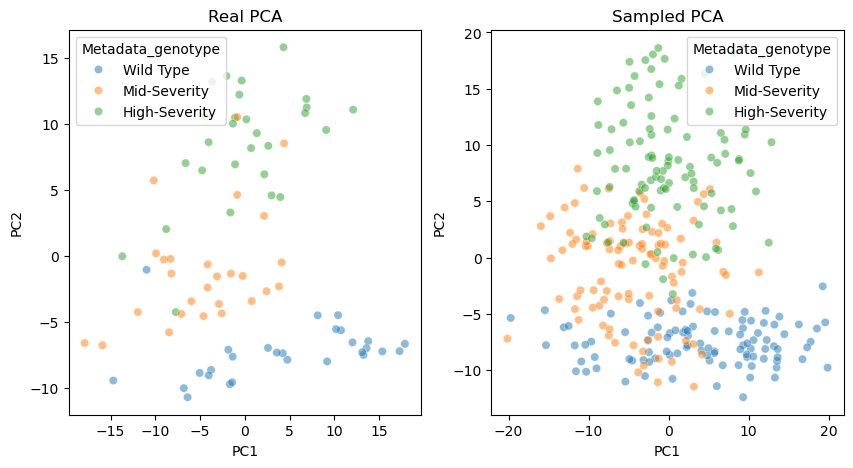

In [16]:
# annotate the genotypes of the sampled points
high_severity_sampled_points["Metadata_genotype"] = "High-Severity"
low_severity_sampled_points["Metadata_genotype"] = "Mid-Severity"
wt_sampled_points["Metadata_genotype"] = "Wild Type"
# concat the genotype sampled points
sampled_points = pd.concat(
    [wt_sampled_points, low_severity_sampled_points, high_severity_sampled_points]
)

# plot the first 2 PCA components from the actual data
# set up subplots
plt.figure(figsize=(10, 5))
# subplot 1
plt.subplot(1, 2, 1)
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=mean_aggregated_data_pca,
    hue="Metadata_genotype",
    alpha=0.5,
)
plt.title("Real PCA")

# plot the first 2 PCA components from the sampled data
# subplot 2
plt.subplot(1, 2, 2)
sns.scatterplot(
    x="PC1",
    y="PC2",
    data=sampled_points,
    hue="Metadata_genotype",
    alpha=0.5,
)
plt.title("Sampled PCA")
plt.show()